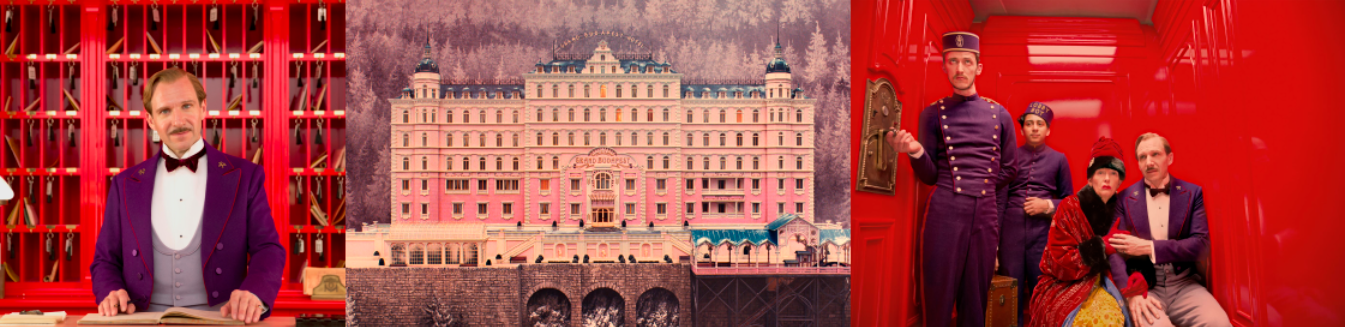

# Прогнозирование оттока клиентов в сети отелей

**Цель работы:**\
Сделать модель, которая спрогнозирует отменит ли клиент бронь. \
Если модель прогнозирует отмену, клиенту предлагается внести депозит 80% от стоимости номера за одни сутки и затрат на разовую уборку.


Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В зависимости от типа номера назначается стоимость за одну ночь; есть также затраты на уборку (цифры ниже в коде). Если клиент снял номер надолго, то убираются каждые два дня. 


Расчитать увеличение прибыли, которое может произойти после внедрения модели. Расходы на разработку модели 0.4 млн. не должны превысить финансовый эффект от модели.

**Ход работы**:
1) Cкачать данные, изучить их и обработать.<br>
2) На обучающей выборке разработать различные ML-модели, определить наилучшую.<br>
3) Проверить выбранную модель на тестовой выборке.<br>
4) Вычислить финансовый эффект от внедрения модели.

### Открытие файлов с данными

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # вывод на экран всех колонок
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate

In [2]:
# создакние класса для выделения текста разными цветами
class color:
   PURPLE    = '\033[95m'
   CYAN      = '\033[96m'
   DARKCYAN  = '\033[36m'
   BLUE      = '\033[94m'
   GREEN     = '\033[92m'
   YELLOW    = '\033[93m'
   RED       = '\033[91m'
   BOLD      = '\033[1m'
   UNDERLINE = '\033[4m'
   END       = '\033[0m'

In [3]:
try:
    data      = pd.read_csv('../../09 сборный проект 2/hotel_train.csv')
    data_test = pd.read_csv('../../09 сборный проект 2/hotel_test.csv')
except:
    try:
        data      = pd.read_csv('/datasets/hotel_train.csv')
        data_test = pd.read_csv('/datasets/hotel_test.csv')
    except:
        data      = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
        data_test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')

### Предобработка и исследовательский анализ данных

In [4]:
data.info() # общая информация по обучающему df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [5]:
data_test.info() # общая информация по тестовому df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Пропусков нет. Названия признаков и их тип совпадают в двух df. Обучающий df примерно в 2 раза больше тестового.\
Четыре признака типа float, что нелогично для них. Переведём в int (будет занимать меньше памяти и визуально проще восприниматься).

In [6]:
data.head(3)

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0   0            0        7.0               2015               July   
1   1            0       14.0               2015               July   
2   2            0        0.0               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     1     1.0       0.0     0.0   
1                        0                     2     2.0       0.0     0.0   
2                        0                     2     2.0       0.0     0.0   

        meal country distribution_channel  is_repeated_guest  \
0  BB            GBR               Direct                  0   
1  BB            GBR                TA/TO                  0   
2  BB            PRT               Direct                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0   A                  
1                       0                               0   A                  
2                       0                               0   C                  

   booking_changes  days_in_waiting_list customer_type  \
0                0                     0     Transient   
1                0                     0     Transient   
2                0                     0     Transient   

   required_car_parking_spaces  total_of_special_requests  total_nights  
0                            0                          0             1  
1                            0                          1             2  
2                            0                          0             2

In [7]:
# перевод четырёх признаков из float в int
for d in (data,data_test):
    d[['lead_time','adults','children','babies']] = d[['lead_time','adults','children','babies']].astype(int)

In [8]:
# описание всех признаков в двух df'ах
data.describe(include='all').join(data_test.describe(include='all'),rsuffix='_t').sort_index(axis=1).round(2)

adults  adults_t  arrival_date_day_of_month  \
count   65229.00  32412.00                   65229.00   
unique       NaN       NaN                        NaN   
top          NaN       NaN                        NaN   
freq         NaN       NaN                        NaN   
mean        1.84      1.86                      15.85   
std         0.48      0.49                       8.75   
min         0.00      0.00                       1.00   
25%         2.00      2.00                       8.00   
50%         2.00      2.00                      16.00   
75%         2.00      2.00                      23.00   
max         4.00      4.00                      31.00   

        arrival_date_day_of_month_t arrival_date_month arrival_date_month_t  \
count                      32412.00              65229                32412   
unique                          NaN                 12                    8   
top                             NaN            October                  May   
freq                            NaN               9255                 5262   
mean                          15.66                NaN                  NaN   
std                            8.77                NaN                  NaN   
min                            1.00                NaN                  NaN   
25%                            8.00                NaN                  NaN   
50%                           15.50                NaN                  NaN   
75%                           23.00                NaN                  NaN   
max                           31.00                NaN                  NaN   

        arrival_date_week_number  arrival_date_week_number_t  \
count                   65229.00                    32412.00   
unique                       NaN                         NaN   
top                          NaN                         NaN   
freq                         NaN                         NaN   
mean                       31.34                       17.80   
std                        13.46                        9.18   
min                         1.00                        1.00   
25%                        21.00                       10.00   
50%                        34.00                       18.00   
75%                        42.00                       25.00   
max                        53.00                       35.00   

        arrival_date_year  arrival_date_year_t    babies  babies_t  \
count            65229.00              32412.0  65229.00  32412.00   
unique                NaN                  NaN       NaN       NaN   
top                   NaN                  NaN       NaN       NaN   
freq                  NaN                  NaN       NaN       NaN   
mean              2015.72               2017.0      0.01      0.01   
std                  0.45                  0.0      0.10      0.08   
min               2015.00               2017.0      0.00      0.00   
25%               2015.00               2017.0      0.00      0.00   
50%               2016.00               2017.0      0.00      0.00   
75%               2016.00               2017.0      0.00      0.00   
max               2016.00               2017.0     10.00      2.00   

        booking_changes  booking_changes_t  children  children_t country  \
count          65229.00           32412.00  65229.00    32412.00   65229   
unique              NaN                NaN       NaN         NaN     155   
top                 NaN                NaN       NaN         NaN     PRT   
freq                NaN                NaN       NaN         NaN   28831   
mean               0.19               0.22      0.07        0.08     NaN   
std                0.59               0.64      0.33        0.34     NaN   
min                0.00               0.00      0.00        0.00     NaN   
25%                0.00               0.00      0.00        0.00     NaN   
50%                0.00               0.00      0.00        0.00     NaN   
75%   

Подозрителные значения: babies - 10; booking_changes - 17; days_in_waiting_list - 259

In [9]:
# кол-во несостыковок в сумме ночей будни/выходные и общем числе ночей
for n,d in [('обучающий df',data),('тестовый df',data_test)]:
    print(f"{n:13s} - {(d['stays_in_week_nights']+d['stays_in_weekend_nights'] != d['total_nights']).sum()} несостыковок")

обучающий df  - 0 несостыковок
тестовый df   - 0 несостыковок


In [10]:
# кол-во бронирований без взрослых
for n,d in [('обучающий df',data),('тестовый df',data_test)]:
    print(f"{n:13s} - {d.query('adults == 0').shape[0]} бронирований")

обучающий df  - 166 бронирований
тестовый df   - 69 бронирований


Дети до 14 лет не могут без взрослых бронировать номера. Считаем данные нулевые значения пропусками и заполняем медианой:

In [11]:
for d in [data, data_test]:
    d.loc[d['adults']==0,'adults'] = d['adults'].median()

In [12]:
# число полных явных дубликатов
for n,d in [('обучающий df',data),('тестовый df',data_test)]:
    print(f"{n:13s} - {d.duplicated().sum()} дубликатов")

обучающий df  - 0 дубликатов
тестовый df   - 0 дубликатов


In [13]:
# число дубликатов среди 'id'
for n,d in [('обучающий df',data),('тестовый df',data_test)]:
    print(f"{n:13s} - {d['id'].duplicated().sum()} id-дубликатов")

обучающий df  - 0 id-дубликатов
тестовый df   - 0 id-дубликатов


In [14]:
# поиск неявных дубликатов в категориальных признаках и удаление пробелов
for n,d in [('обучающий df',data),('тестовый df',data_test)]:
    for j in [i for i in d if d[i].dtype == object]:
        print((color.YELLOW+n+  ': '+j+color.END)*(n=='обучающий df')+
              (color.DARKCYAN+n+': '+j+color.END)*(n=='тестовый df'),'\n',
              sorted(d[j].unique()),'\n')
        
        d[j] = d[j].str.strip()                       # удаление пробелов по краям

обучающий df: arrival_date_month 
 ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September'] 

обучающий df: meal 
 ['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       '] 

обучающий df: country 
 ['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MWI', 'MYS', 'NAM', 'NGA',

* meal - задублированное значение SC и пробелы
* reserved_room_type - пробелы

Пробелы удалены, задублированность в meal убрана.

In [15]:
# число полных явных дубликатов после удаления пробелов и задублированности в meal; а также без учёта id
for n,d in [('обучающий df',data.drop('id',axis=1)),('тестовый df',data_test.drop('id',axis=1))]:
    print(f"{n:13s} - {d.duplicated().sum()} дубликатов")

обучающий df  - 21377 дубликатов
тестовый df   - 7717 дубликатов


Выявилось множество дубликатов без учёта id. Посмотрим на них построчно. Количество каждой уникальной строки указано в последнем столбце size:

In [16]:
data.drop('id',axis=1).groupby(data.drop('id',axis=1).columns.tolist(), as_index=False).size().\
query('size>1').sort_values(by='size',ascending=False).head(10)

is_canceled  lead_time  arrival_date_year arrival_date_month  \
43482            1        277               2016           November   
38326            1         68               2016           February   
35934            1         34               2015           December   
42393            1        188               2016               June   
41751            1        158               2016                May   
38479            1         71               2016               June   
29298            0        164               2015            October   
41949            1        166               2016           November   
43659            1        304               2016           November   
43664            1        305               2016           November   

       arrival_date_week_number  arrival_date_day_of_month  \
43482                        46                          7   
38326                         8                         17   
35934                        50                          8   
42393                        25                         15   
41751                        22                         24   
38479                        25                         14   
29298                        40                          2   
41949                        45                          1   
43659                        45                          3   
43664                        45                          4   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
43482                        1                     2     2.0         0   
38326                        0                     2     2.0         0   
35934                        0                     2     1.0         0   
42393                        0                     2     1.0         0   
41751                        0                     2     1.0         0   
38479                        0                     3     1.0         0   
29298                        0                     2     1.0         0   
41949                        0                     3     1.0         0   
43659                        0                     3     2.0         0   
43664                        1                     2     2.0         0   

       babies meal country distribution_channel  is_repeated_guest  \
43482       0   BB     PRT                TA/TO                  0   
38326       0   BB     PRT                TA/TO                  0   
35934       0   BB     PRT                TA/TO                  0   
42393       0   BB     PRT                TA/TO                  0   
41751       0   BB     PRT                TA/TO                  0   
38479       0   BB     PRT                TA/TO                  0   
29298       0   BB     PRT                TA/TO                  0   
41949       0   BB     PRT                TA/TO                  0   
43659       0   BB     PRT                TA/TO                  0   
43664       0   BB     PRT                TA/TO                  0   

       previous_cancellations  previous_bookings_not_canceled  \
43482                       0                               0   
38326                       1                               0   
35934                       1                               0   
42393                       0                               0   
41751                       0                               0   
38479                       0                               0   
29298                       0                               0   
41949                       0                               0   
43659                       0                               0   
43664                       0                               0   

      reserved_room_type  booking_changes  days_in_waiting_list  \
43482                  A                0                     0   
38326                  A                0                     0   
35934                  A               

У нас нет оснований предполагать, что данные дубликаты являются технической ошибкой. Вполне вероятно такое массовое бронирование турагенством с одними метриками, а потом такая же массовая отмена брони.\
Ничего не делаем с найденными дубликатами. Оставляем, как есть.

#### преобразование времени

In [17]:
# кодируем месяц (конвертируем из строчного формата в числовой)
month_dict = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
              'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
for d in (data,data_test):
    d['arrival_date_month'] = d['arrival_date_month'].apply(lambda x: month_dict[x])

In [18]:
# создаём столбцы 'arrival_date' в форматах datetime и unix
for d in (data,data_test):
    d['arrival_date']=pd.to_datetime({'year': d['arrival_date_year'],
                                      'month':d['arrival_date_month'],
                                      'day':  d['arrival_date_day_of_month']})
    d['arrival_date_unix'] = data['arrival_date'].apply(lambda x: x.timestamp())

#### country

In [19]:
# объединим в df количества стран из обучающего и тестового df
country_all = pd.DataFrame(data     ['country'].value_counts()).join\
             (pd.DataFrame(data_test['country'].value_counts()), lsuffix='_train', rsuffix='_test', how='outer').\
                           sort_values(by='country_train',ascending=False)
country_all.head(3)

country_train  country_test
PRT        28831.0        9887.0
FRA         5974.0        3477.0
GBR         5109.0        3927.0

In [20]:
# страны присутствующие в одном df, но отсутствующие в другом
country_all.query('country_train.isna()|country_test.isna()').T

OMN   GEO  MKD  BOL  ARM  BRB  GGY  TMP  KHM  MWI  GLP  VGB  \
country_train  10.0  10.0  9.0  9.0  6.0  4.0  3.0  3.0  2.0  2.0  2.0  1.0   
country_test    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               ZMB  UGA  SMR  RWA  BDI  BFA  BWA  CYM  DMA  GUY  HND  KNA  \
country_train  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
country_test   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               LCA  MLI  MMR  NAM  NIC  PLW  PYF  ASM  ATF  BHS  CAF  FJI  \
country_train  1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN   
country_test   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  3.0  1.0   

               FRO  GHA  GTM  KIR  LAO  MDG  MRT  MYT  NCL  NPL  SDN  SLE  \
country_train  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
country_test   1.0  2.0  4.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

               TGO  UMI  
country_train  NaN  NaN  
country_test   1.0  1.0

Страны, непересекающиеся в обучающем и тестовом df'ах - небольшие страны.

In [21]:
# число непересекающихся стран в обучающем и тестовом df
country_all.query('country_train.isna()|country_test.isna()').shape[0]

50

In [22]:
# число стран, которые есть в обучающем df, но нет в тестовом
country_all.query('country_test.isna()').shape[0]

31

In [23]:
# число стран, которые есть в тестовом df, но нет в обучающем
country_all.query('country_train.isna()').shape[0]

19

#### Диаграммы распределения признаков

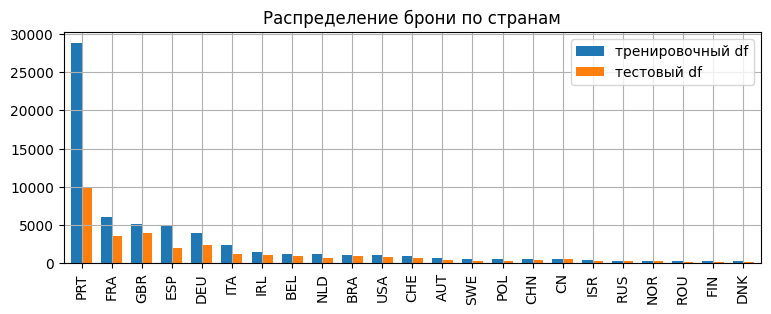

In [24]:
country_all[:23].plot(kind='bar',grid=True,title='Распределение брони по странам',figsize=(9,3),width=0.7)
plt.legend(['тренировочный df', 'тестовый df']); plt.show()

Далее в целях удобства визуального восприятия для признаков с небольшим количеством уникальных значений строим столбчатые диаграммы, с большим - гистограммы и диаграммы разброса.

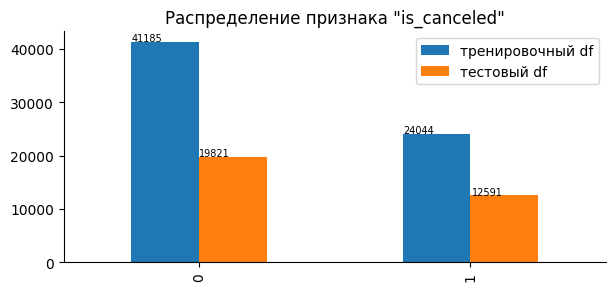

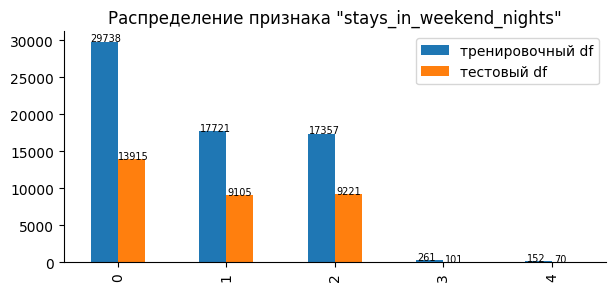

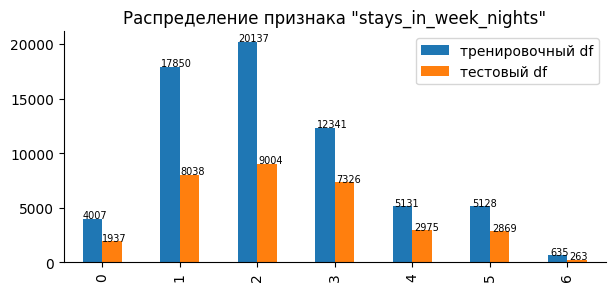

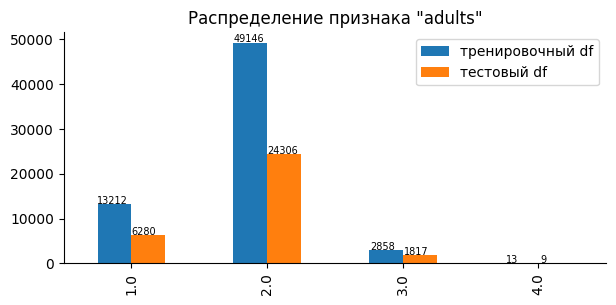

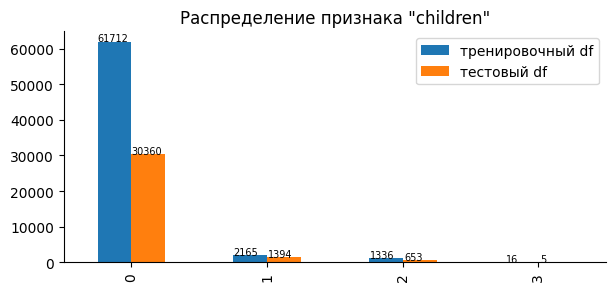

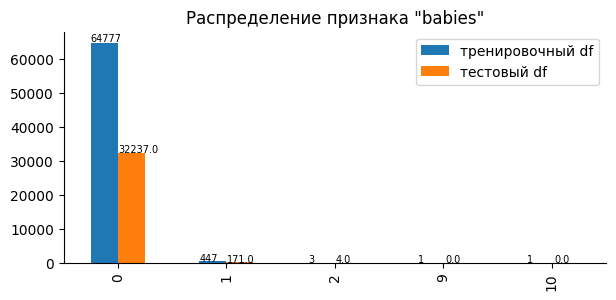

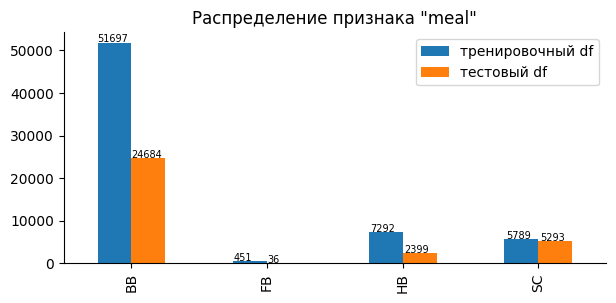

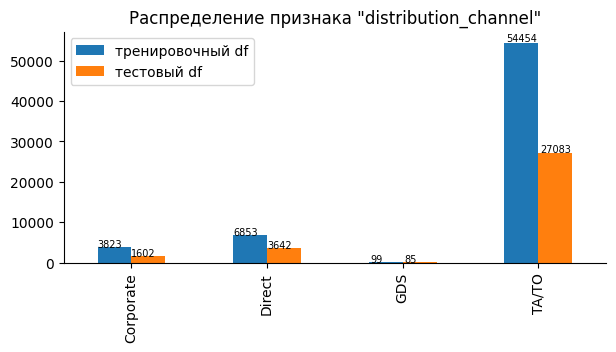

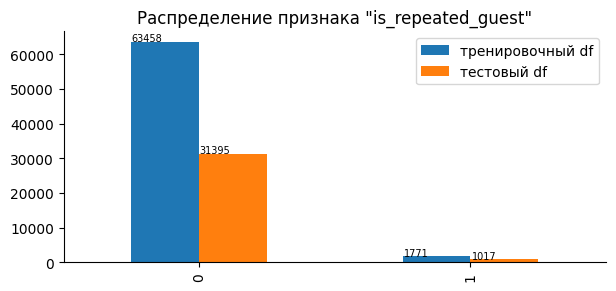

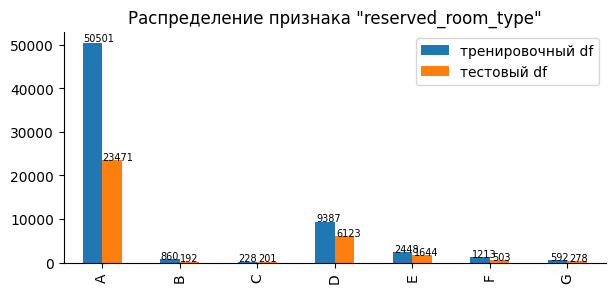

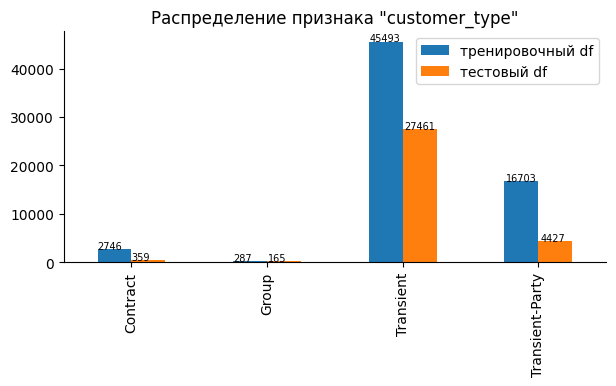

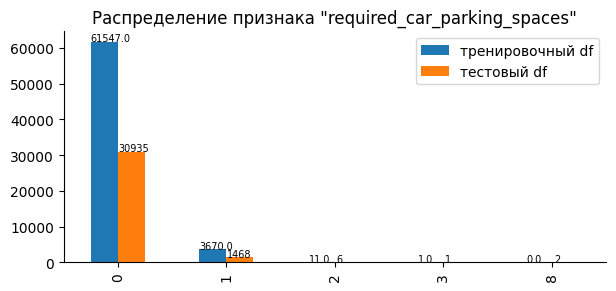

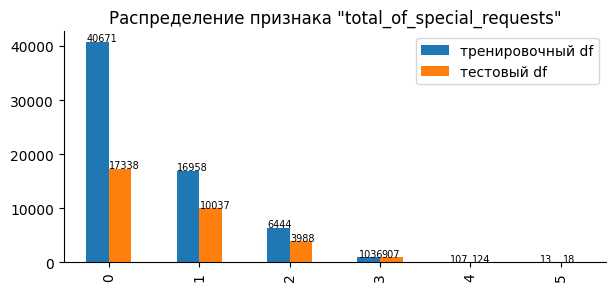

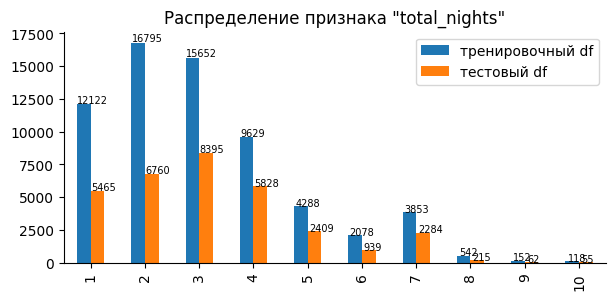

In [25]:
# столбчатые диаграммы признаков с числом уник. значений до 10 \'arrival_date_year' (перенесём в гист-мы ко всем arrival)
for col in [i for i in data if len(data[i].unique())<=10 and i != 'arrival_date_year']:
    ax = pd.DataFrame(data     [col].value_counts()).join\
        (pd.DataFrame(data_test[col].value_counts()),lsuffix='_train',rsuffix='_test',how='outer').sort_index().\
         plot(kind='bar',figsize=(7,3),title='Распределение признака "'+col+'"')
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),fontsize=7)

    plt.legend(['тренировочный df', 'тестовый df']); sns.despine(ax=ax); plt.show()

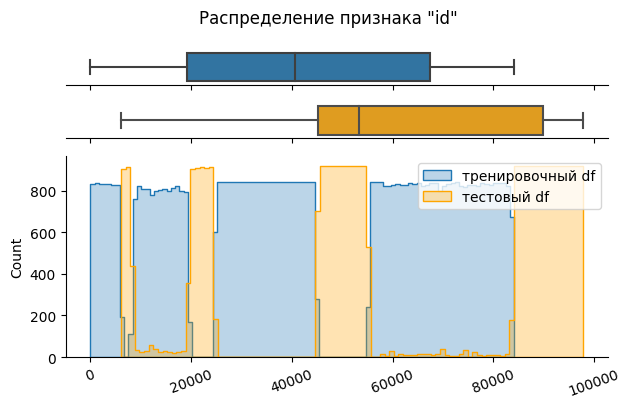

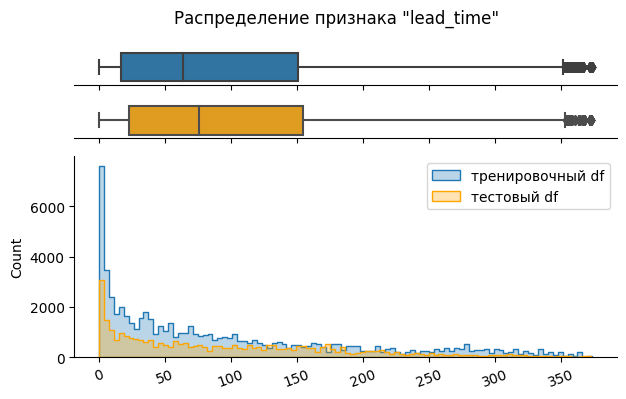

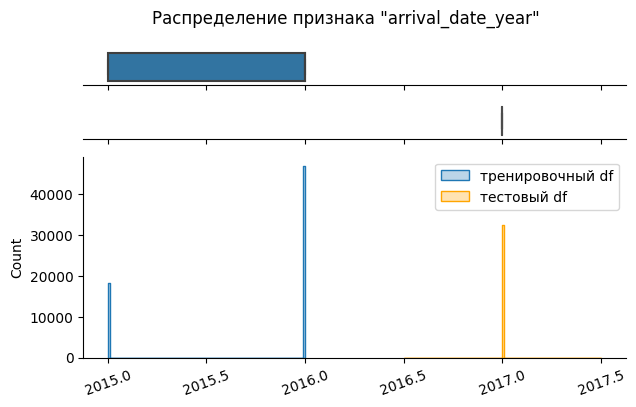

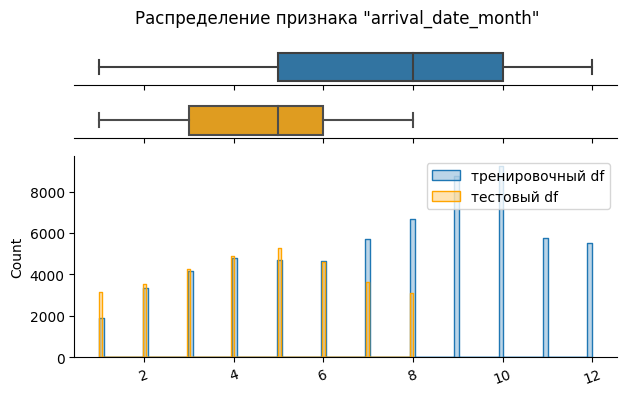

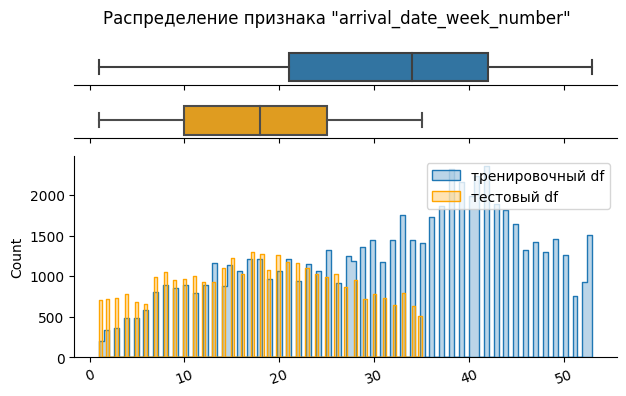

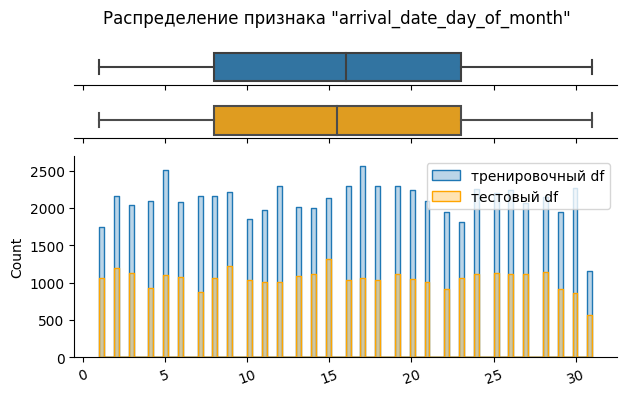

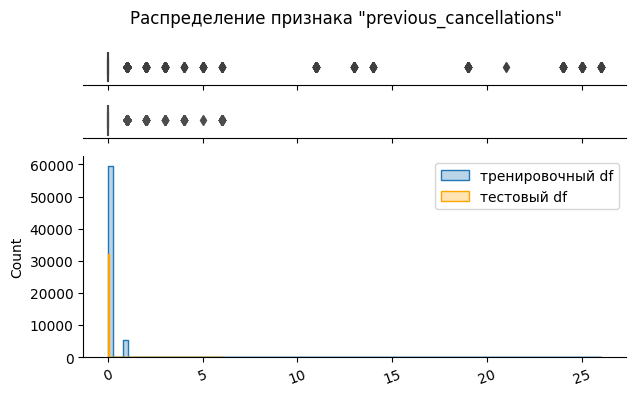

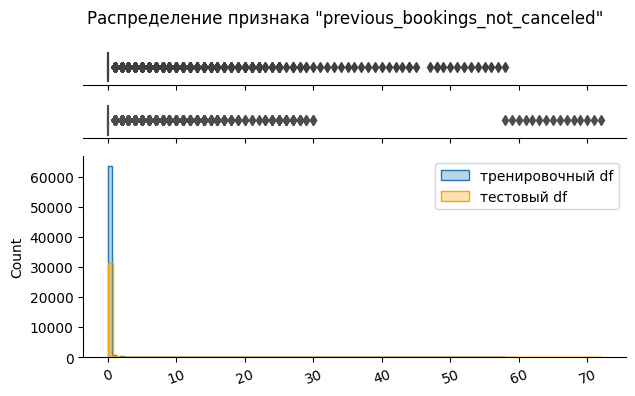

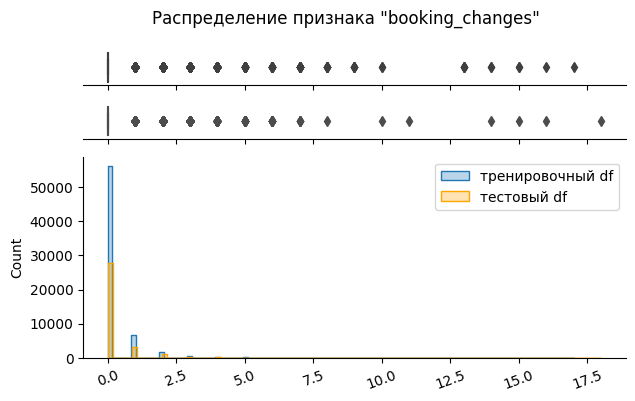

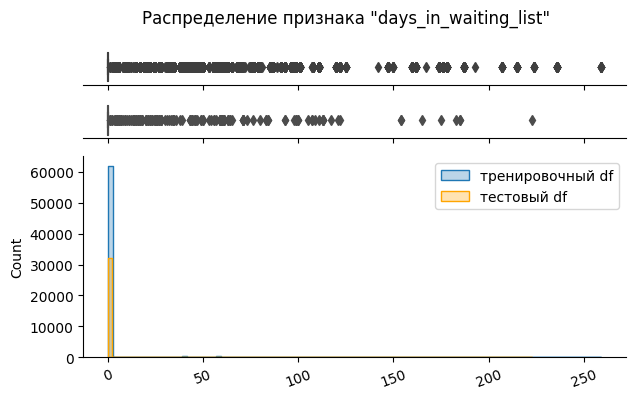

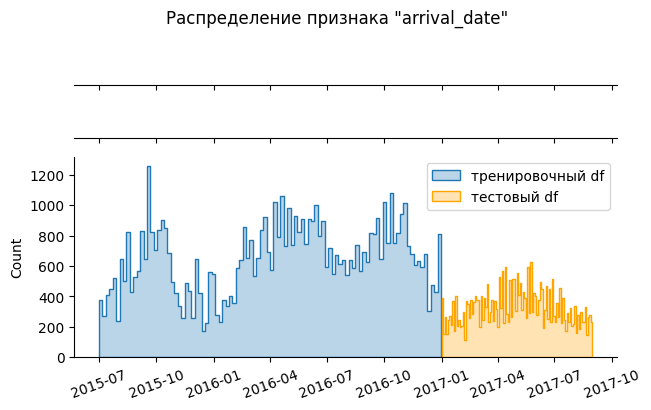

In [26]:
# диаграммы размаха и гистограммы признаков с числом уник.зн.>10 + 'arrival_date_year' \ 'country','arrival_date_unix'
for col in [i for i in data if len(data[i].unique()) >  10                  and 
                                                   i != 'country'           and 
                                                   i != 'arrival_date_unix' or
                                                   i == 'arrival_date_year']:
    f, (ax_box, ax_box_test, ax_hist) = plt.subplots(3,sharex=True,gridspec_kw={"height_ratios":(.15, .15, .85)},figsize=(7,4))
    try:    # для 'arrival_date'(boxplot не строит datetime)
        sns.boxplot(x=data[col],      ax=ax_box).                     set(xlabel=None)
        sns.boxplot(x=data_test[col], ax=ax_box_test, color='orange').set(xlabel=None)
    except:
        pass
    sns.histplot(x=data[col],      bins=100,ax=ax_hist,alpha=0.3,element='step').               set(xlabel=None)
    sns.histplot(x=data_test[col], bins=100,ax=ax_hist,alpha=0.3,color='orange',element='step').set(xlabel=None)
    
    plt.legend(['тренировочный df', 'тестовый df']); f.suptitle(f'Распределение признака "{col}"')
    ax_hist.tick_params(axis='x', labelrotation=20)
    ax_box.set(yticks=[]); ax_box_test.set(yticks=[])
    sns.despine(ax=ax_hist); sns.despine(ax=ax_box, left=True); sns.despine(ax=ax_box_test, left=True)

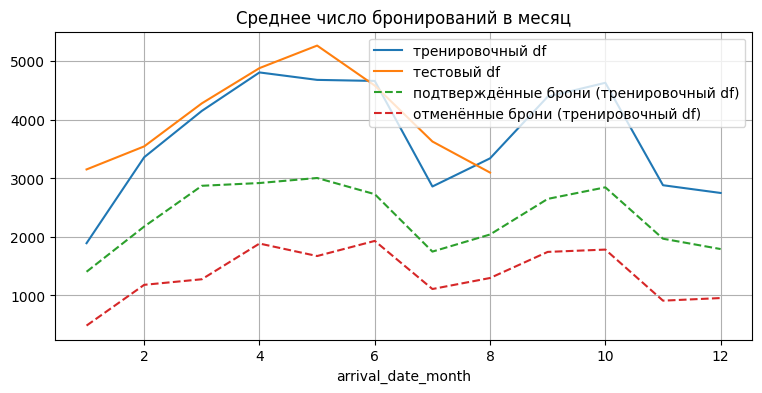

In [27]:
data.                          groupby(['arrival_date_year','arrival_date_month'])['id'].count().\
                               groupby('arrival_date_month').mean().\
                               plot(grid=True,figsize=(9,4),legend=True,label='тренировочный df',
                                    title='Среднее число бронирований в месяц')
data_test.                     groupby(['arrival_date_year','arrival_date_month'])['id'].count().\
                               groupby('arrival_date_month').mean().\
                               plot(grid=True,legend=True,label='тестовый df')
data.query('is_canceled == 0').groupby(['arrival_date_year','arrival_date_month'])['id'].count().\
                               groupby('arrival_date_month').mean().\
                               plot(grid=True,legend=True,style='--',label='подтверждённые брони (тренировочный df)')
data.query('is_canceled == 1').groupby(['arrival_date_year','arrival_date_month'])['id'].count().\
                               groupby('arrival_date_month').mean().\
                               plot(grid=True,legend=True,style='--',label='отменённые брони (тренировочный df)')
plt.show()

#### Детализация нескольких признаков (с выбросами)

In [28]:
# уникальные значения количеств
for col in ['previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list']:
    display(pd.DataFrame(data[col].value_counts().sort_index()).T)

0     1   2   3   4   5   6   11  13  14  19  21  \
previous_cancellations  59591  5367  54  51   5  13   7  35  12  11  17   1   

                        24  25  26  
previous_cancellations  28  19  18

0    1    2    3    4   5   6   7   8   9   \
previous_bookings_not_canceled  63686  645  252  136  114  89  56  34  25  23   

                                10  11  12  13  14  15  16  17  18  19  20  \
previous_bookings_not_canceled  21  16  14   9   8   7   6   5   5   5   5   

                                21  22  23  24  25  26  27  28  29  30  31  \
previous_bookings_not_canceled   8   7   2   3  10   1   3   2   2   1   1   

                                32  33  34  35  36  37  38  39  40  41  42  \
previous_bookings_not_canceled   1   1   1   1   1   1   1   1   1   1   1   

                                43  44  45  47  48  49  50  51  52  53  54  \
previous_bookings_not_canceled   1   2   1   1   2   1   1   1   1   1   1   

                                55  56  57  58  
previous_bookings_not_canceled   1   1   1   1

0     1     2    3    4   5   6   7   8   9   10  13  14  \
booking_changes  56195  6615  1754  413  149  42  19  18   7   5   2   4   2   

                 15  16  17  
booking_changes   2   1   1

0    1    2    3    4    5    6    8    9    10   11   \
days_in_waiting_list  62005    3    2   59   20    2   11    4   13   27    4   

                      12   13   14   15   17   19   20   21   22   24   25   \
days_in_waiting_list    2    1    1   52   43   30   25   35   52   19   18   

                      27   28   30   31   32   33   34   35   38   39   40   \
days_in_waiting_list   23   45    1  126   18    4   20   95   72  185   28   

                      41   42   43   44   45   46   47   48   49   50   53   \
days_in_waiting_list   63   30   16  137   65   87   17   51   15   75    5   

                      55   56   57   58   59   60   61   62   63   65   68   \
days_in_waiting_list   10   42   24  164    8   34   15   60   80   27   41   

                      69   70   71   72   74   75   76   77   79   80   81   \
days_in_waiting_list   89   18    7    1    1   36    1   63   20   23    1   

                      85   87   89   91   93   96   98   99   101  107  108  \
days_in_waiting_list   15   80    1   50   38   46   55   16   60    3   20   

                      111  120  122  125  142  147  150  160  162  167  174  \
days_in_waiting_list   70   25   38   11    1   30    7   25   30    1   19   

                      176  178  187  193  207  215  224  236  259  
days_in_waiting_list   50   30   45    1   15   21   10   35   10

In [29]:
# бронирования с числом детей более одного
for d in (data,data_test):
    display(d.query('babies>1'))

id  is_canceled  lead_time  arrival_date_year  arrival_date_month  \
7390    9778            0        174               2015                   9   
15516  18273            0         47               2016                  11   
22995  30935            0         37               2016                   1   
41528  59925            0         11               2015                  10   
56050  74658            0          4               2016                   7   

       arrival_date_week_number  arrival_date_day_of_month  \
7390                         36                          2   
15516                        45                          5   
22995                         3                         12   
41528                        42                         11   
56050                        31                         27   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
7390                         1                     4     2.0         0   
15516                        2                     2     2.0         0   
22995                        0                     2     2.0         0   
41528                        2                     1     1.0         0   
56050                        0                     4     2.0         0   

       babies meal country distribution_channel  is_repeated_guest  \
7390        2   HB     PRT               Direct                  0   
15516       2   HB     GBR                TA/TO                  0   
22995      10   BB     PRT                TA/TO                  0   
41528       9   BB     GBR            Corporate                  0   
56050       2   BB     DNK                TA/TO                  0   

       previous_cancellations  previous_bookings_not_canceled  \
7390                        0                               0   
15516                       0                               0   
22995                       0                               0   
41528                       0                               0   
56050                       0                               0   

      reserved_room_type  booking_changes  days_in_waiting_list  \
7390                   C                1                     0   
15516                  A                1                     0   
22995                  D                1                     0   
41528                  A                1                     0   
56050                  D                2                     0   

         customer_type  required_car_parking_spaces  \
7390         Transient                            1   
15516        Transient                            0   
22995        Transient                            0   
41528  Transient-Party                            0   
56050        Transient                            0   

       total_of_special_requests  total_nights arrival_date  arrival_date_unix  
7390                           2             5   2015-09-02       1.441152e+09  
15516                          5             4   2016-11-05       1.478304e+09  
22995                          1             2   2016-01-12       1.452557e+09  
41528                          0             3   2015-10-11       1.444522e+09  
56050                          2             4   2016-07-27       1.469578e+09

id  is_canceled  lead_time  arrival_date_year  arrival_date_month  \
3812   20739            0         31               2017                   2   
7535   24492            0        247               2017                   8   
18827  84319            0         19               2017                   1   
22193  87685            0         13               2017                   3   

       arrival_date_week_number  arrival_date_day_of_month  \
3812                          8                         19   
7535                         33                         16   
18827                         2                          8   
22193                        11                         18   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
3812                         1                     0     2.0         0   
7535                         2                     6     2.0         0   
18827                        2                     2     2.0         0   
22193                        0                     1     2.0         1   

       babies meal country distribution_channel  is_repeated_guest  \
3812        2   BB     PRT                TA/TO                  0   
7535        2   BB     PRT                TA/TO                  0   
18827       2   BB     PRT               Direct                  0   
22193       2   BB     PRT               Direct                  0   

       previous_cancellations  previous_bookings_not_canceled  \
3812                        0                               0   
7535                        0                               0   
18827                       0                               0   
22193                       0                               0   

      reserved_room_type  booking_changes  days_in_waiting_list  \
3812                   A                2                     0   
7535                   C                0                     0   
18827                  E                1                     0   
22193                  D                3                     0   

         customer_type  required_car_parking_spaces  \
3812   Transient-Party                            1   
7535         Transient                            0   
18827        Transient                            0   
22193        Transient                            1   

       total_of_special_requests  total_nights arrival_date  arrival_date_unix  
3812                           2             1   2017-02-19       1.463098e+09  
7535                           1             8   2017-08-16       1.463702e+09  
18827                          0             4   2017-01-08       1.441411e+09  
22193                          2             1   2017-03-18       1.448237e+09

Теоретически брони с 9-ю и 10-ю детьми могли быть. Но, глядя на столбчатую диаграмму, видим единичность этих двух прецедентов. Отсутствуют брони с числом детей от 3 до 8.  Данный выброс может отразится на модели и привести к ухудшению метрик качества. Удалим данные две брони из рассмотрения:

In [30]:
data.drop([22995,41528],inplace=True)

Бронирований с 2 младенцами тоже слишком мало, чтобы использовать их для прогноза. Заменим число младенцев в данных записях на 1. Таким образом признак babies станет бинарным.

In [31]:
for d in (data,data_test):
    d.loc[d['babies']==2,'babies'] = 1

#### Вывод по исходным данным

* **country** - самое большое число бронирований из Португалии; скорее всего рассматриваемый отель в данном государстве; 50 стран не пересекаются в обучающем и тестовом df; это небольшие страны;
* **is_canceled** - третья часть бронирований отменяется;
* **total_nights** - чаще всего бронируется номер на 2-е ночи;
* **adults, children, babies** - чаще всего в отеле останавливаются двое взрослых без детей; двое взрослых относительно одного взрослого бронируют номер в 4 раза чаще; следовательно отелем чаще пользуются туристы (пары), а не командировочные; вероятно отель в небольшом городе, т.к. наиболее частая бронь на 2 дня; удалили 2 брони с кол-ом детей 9 и 10;
* **meal** - основной тип питания - только завтраки;
* **distribution_channel** - главный источник гостей - туристические агенства;
* **reserved_room_type** - чаще всего бронируется самый дорогой номер типа А;
* **required_car_parking_spaces** - чаще гости отеля путешествуют без личных автомобилей;
* **total_of_special_requests** - в основном доп.запросы гости не делают;
* **id** - брони из обучающей и тестовой выборок не пересекаются и дополняют друг друга (на гистограмме можно уведеть небольшое пересечение - это визуальный эффект из-за много крат меньшего разбиения диапазона на корзины при построении графика 100/100000);
* **lead_time** - от момента бронирования до визита около двух месяцев (медиана);
* **arrival_date** - тренировочный df в интервале 1,5 лет (07.2015 - 12.2016); тестовый df - 8 месяцев (01.2017 - 08.2017); оба df по времени не пересекаются;
* **arrival_date_month** - наиболее востребованные месяцы в межсезонье (май и октябрь); вероятно связано с наиболее комфортной температурой;
* **previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list** - все 4 признака в большинстве случаев со значением 0 и имеют выбросы; значения вполне могут быть реальными, удалять их не имеет смысла; данные выбросы могут коррелировать с целевым признаком.

#### Взаимосвязь признаков

##### Распределение с разбивкой по is_canceled

Рассматриваем только обучающую выборку.

Далее в целях удобства визуального восприятия для признаков с небольшим количеством уникальных значений строим столбчатые диаграммы, с большим - гистограммы и диаграммы разброса.

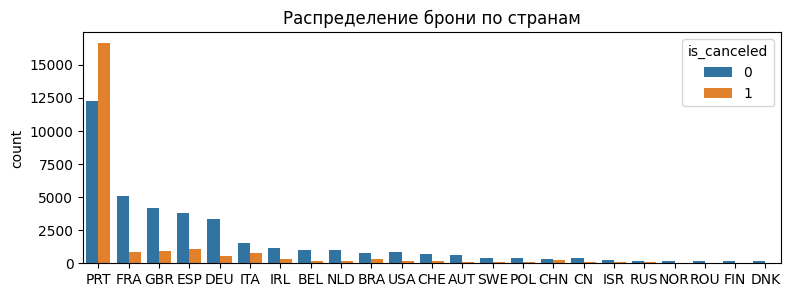

In [32]:
plt.figure(figsize=(9,3))
sns.countplot(data=data,x='country',hue='is_canceled',order=country_all.index[:23]).set(xlabel=None)
plt.title('Распределение брони по странам'); plt.show()

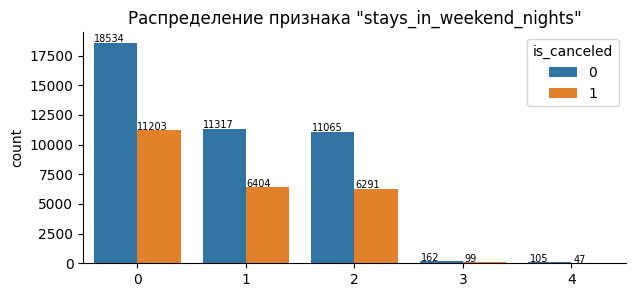

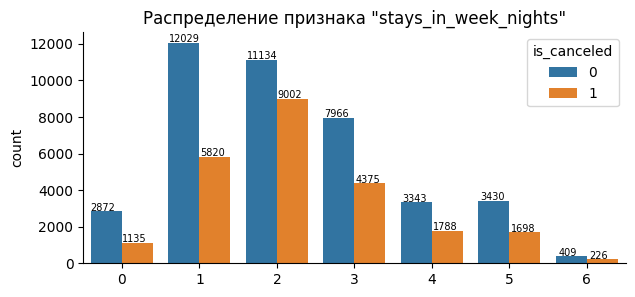

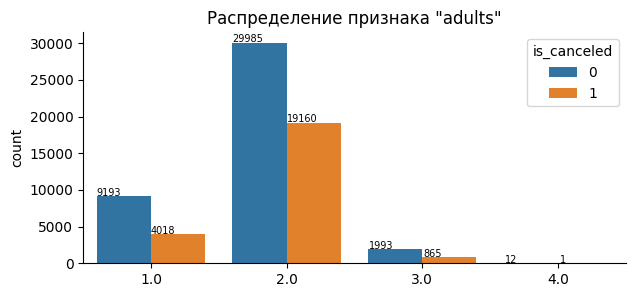

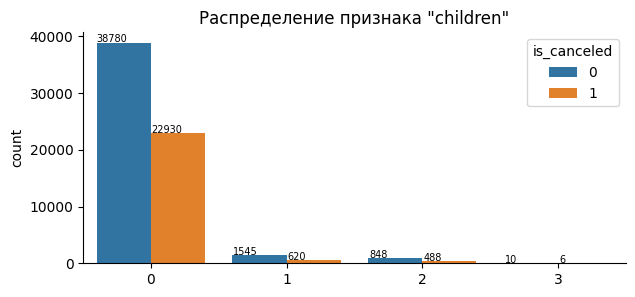

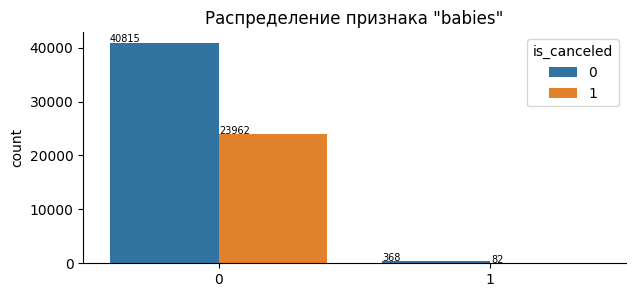

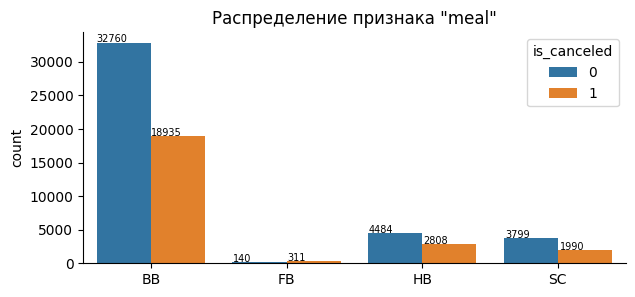

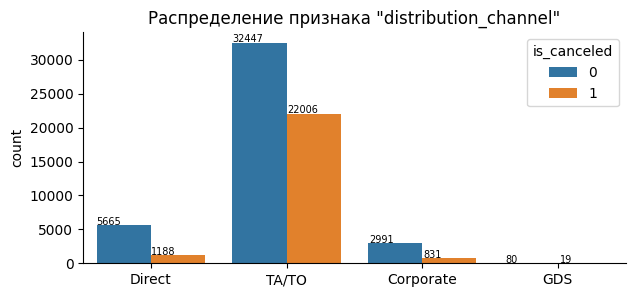

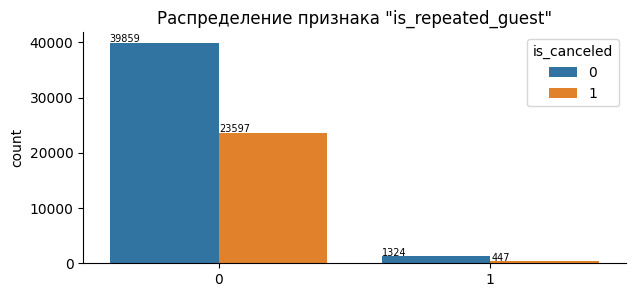

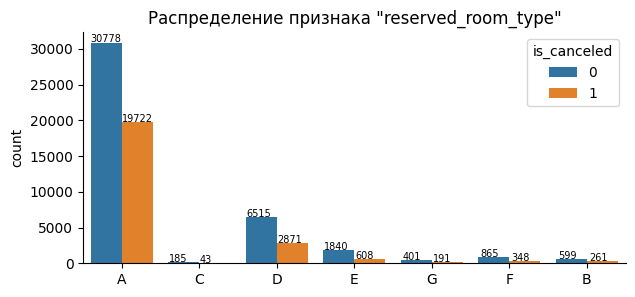

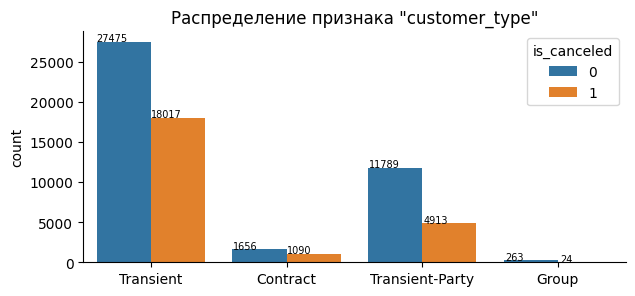

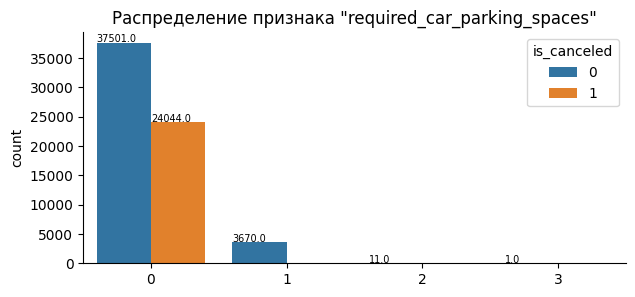

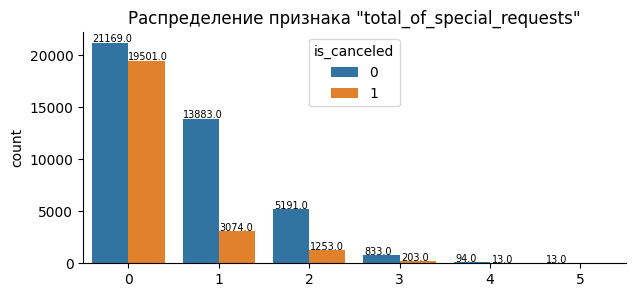

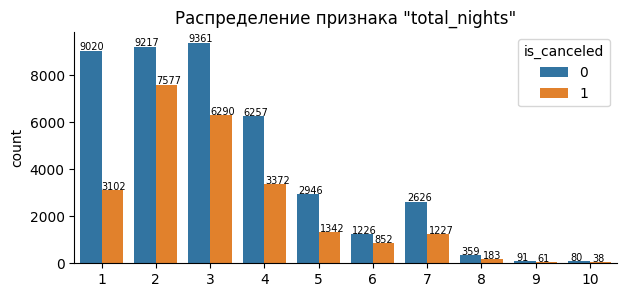

In [33]:
for col in [i for i in data if len(data[i].unique()) <= 10                  and 
                                                   i != 'arrival_date_year' and 
                                                   i != 'is_canceled']:
    plt.figure(figsize=(7,3))
    ax=sns.countplot(data=data,x=col,hue='is_canceled')
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),fontsize=7)
    plt.title(f'Распределение признака "{col}"'); ax.set_xlabel(None); sns.despine(ax=ax); plt.show()

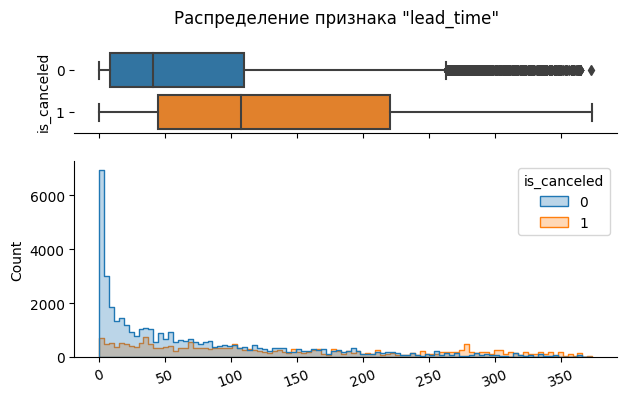

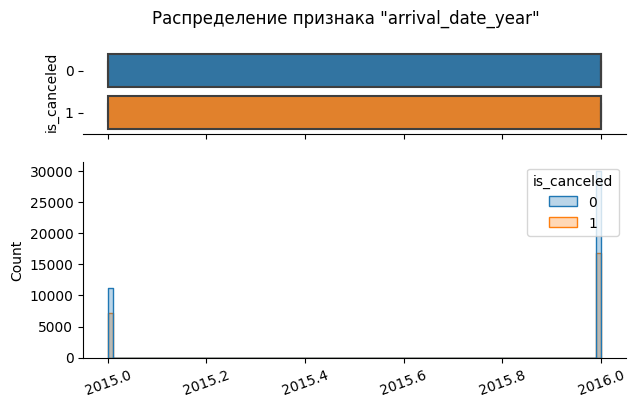

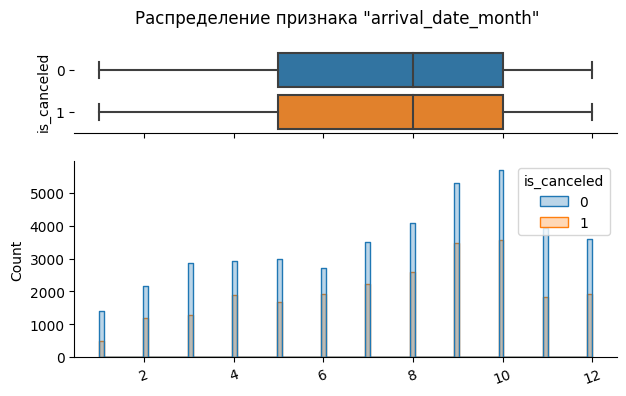

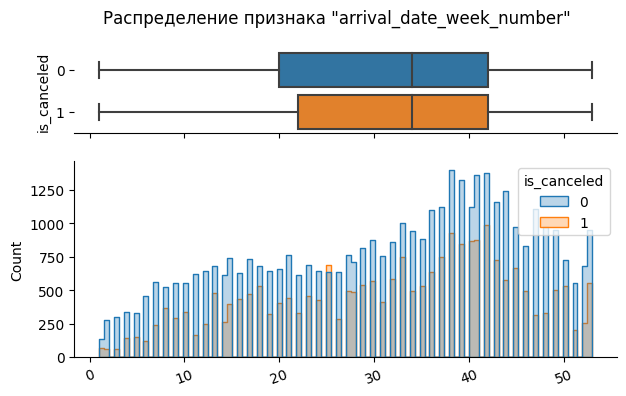

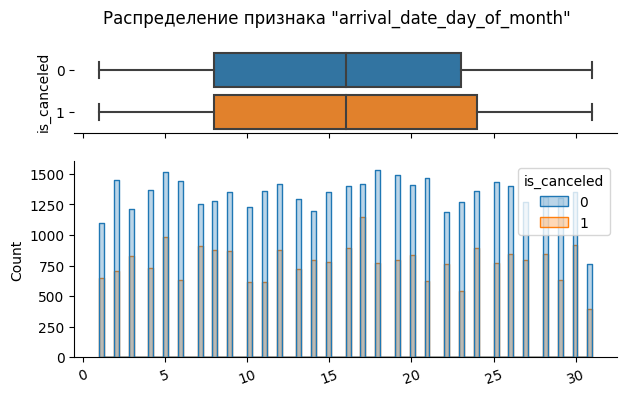

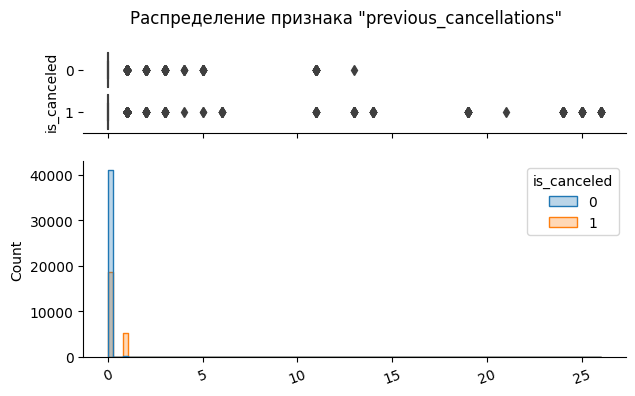

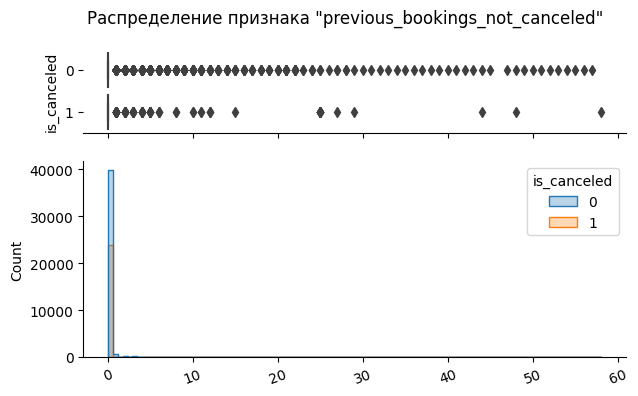

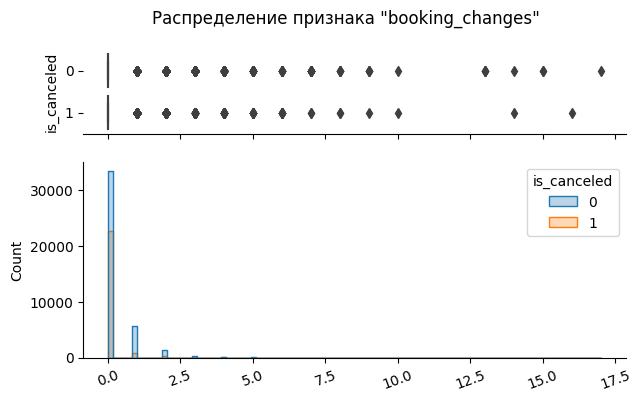

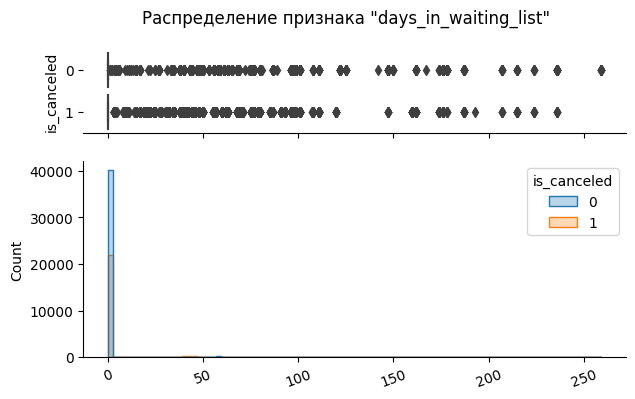

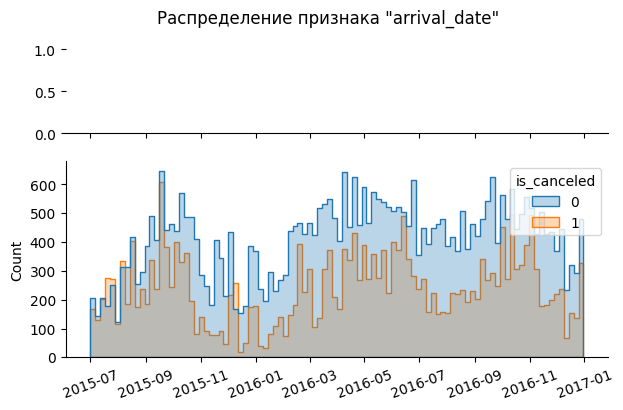

In [34]:
# диаграммы размаха и гистограммы признаков с числом уник.зн.>10 + 'arrival_date_year' \ 'id','country','arrival_date_unix'
for col in [i for i in data if len(data[i].unique()) >  10                   and 
                                                   i != 'country'            and
                                                   i != 'arrival_date_unix'  and
                                                   i != 'id'                 or
                                                   i == 'arrival_date_year']:
    
    f, (ax_box, ax_hist) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.3, .7)},figsize=(7,4))
    try:    # для 'arrival_date'(boxplot не строит datetime)
        sns.boxplot(data=data,x=col,y='is_canceled',orient='h',ax=ax_box).set(xlabel=None)
    except:
        pass
    sns.histplot(data=data, x=col,hue='is_canceled',bins=100, ax=ax_hist,alpha=0.3,element='step').set(xlabel=None)
    
    f.suptitle(f'Распределение признака "{col}"')
    ax_hist.tick_params(axis='x', labelrotation=20)
    sns.despine(ax=ax_hist); sns.despine(ax=ax_box, left=True)

#### Вывод по взаимосвязи

* по признакам, в большинстве случаев, в средем число отказов около 1/3;
* **arrival_date** - с июля по сентябрь 2015 года число отказов примерно ровнялось числу подтверждений; далее число отказов уменьшалось и в итоге вышло в среднем на 1/3 от общего числа броней;
* **country** - больше всего гостей из Португалии; эта страна делает основную выручку; в то же время это единственная страна (по крайне мере, из топ-23) в которой количество отказов превышает число подтверждений;
* **meal** - среди типа питания FB число отказов примерно в 2 раза выше числа подтверждений, что противоречит основному тренду; но и типа FB кратно меньше других типов питания;
* **distribution_channel** - среди тур.агенств отказов больше;
* **lead_time** - чем меньше срок между бронированием и заездом, тем меньше отказов; медиана подтверждённых броней - 40 дней; медиана отменённых - 100;
* **previous_cancellations** - при наличии предыдущих отказов от брони, отмен последнего бронирования больше;
* **required_car_parking_spaces** - путешественники без собственных автомобилей отказываются от брони чаще автолюбителей;
* **total_of_special_requests** - чем больше дополнительных отметок, тем меньше отказов.


#### Ordinal Encoding (вар.1)

Кодирование необходимо, как для ML, так и для определения коэффициентов корреляции.

In [35]:
def o_encoding(d):
    '''кодирует только тип object и убираем id'''
    return pd.DataFrame(encoder.transform(d[[col for col in d if d[col].dtype == object]]),
                                  columns=d[[col for col in d if d[col].dtype == object]].columns,index=d.index).join(
                                          d[[col for col in d if d[col].dtype != object]]).drop('id',axis=1)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
encoder.fit(data[[col for col in data if data[col].dtype == object]])

data_ordinal      = o_encoding(data)
data_test_ordinal = o_encoding(data_test)

#### Корреляция

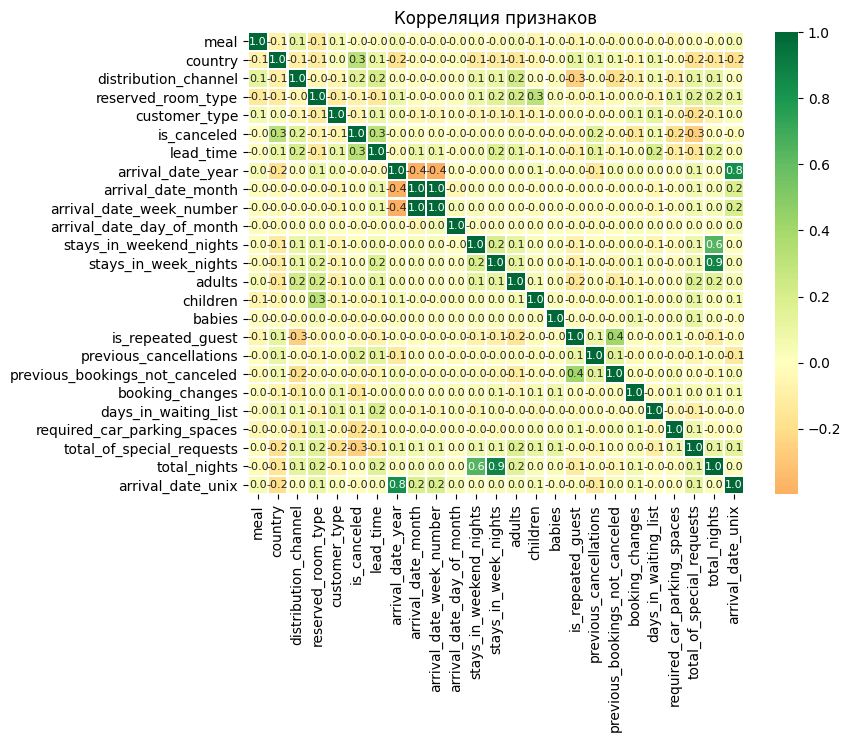

In [36]:
plt.figure(figsize=(8,6))
sns.heatmap(data_ordinal.corr(),cmap='RdYlGn',linewidth=0.8,center= 0,fmt='.1f',annot=True,annot_kws={"size":8})
plt.title('Корреляция признаков'); plt.show()

* is_canceled - слабо коррелирует с country(+), distribution_channel(+), lead_time(+), previous_cancellations(+), total_of_special_requests(-), required_car_parking_spaces(-)  (данную зависимость наблюдаем выше на диаграммах);
* children - слабо коррелирует с reserved_room_type(+); чем больше детей, тем дешевле номер (интересная зависимость; можно предположить связь с психологией отношений пары без детей в начальный период отношений (пускание пыли в глаза) и отношений в долгом браке (экономия);


* мультиколлинеарность; оставляем только признаки, выделенные синим цветом; остальные удаляем за ненадобностью и вредностью; лишние неинформативные признаки усложнят модель, увеличат время выполнения программы и, скорее всего, ухудшат качество предскания:\
\- arrival_date_week_number/<font color='blue'>arrival_date_month</font> - 1;\
\- arrival_date_week_number/arrival_date_year - -0.4;\
\- <font color='blue'>arrival_date_month</font>/arrival_date_year - -0.4;\
\- arrival_date_year/<font color='blue'>arrival_date_unix</font> - 0.8;\
\- total_nights/<font color='blue'>stays_in_weekend_nights</font> - 0.6;\
\- total_nights/<font color='blue'>stays_in_week_nights</font> - 0.9;\
\- previous_bookings_not_canceled/is_repeated_guest - 0.4 (далее в некоторых видах кодирования previous_bookings_not_canceled и previous_cancellations будут заменены одним признаком propensity_to_cancel).

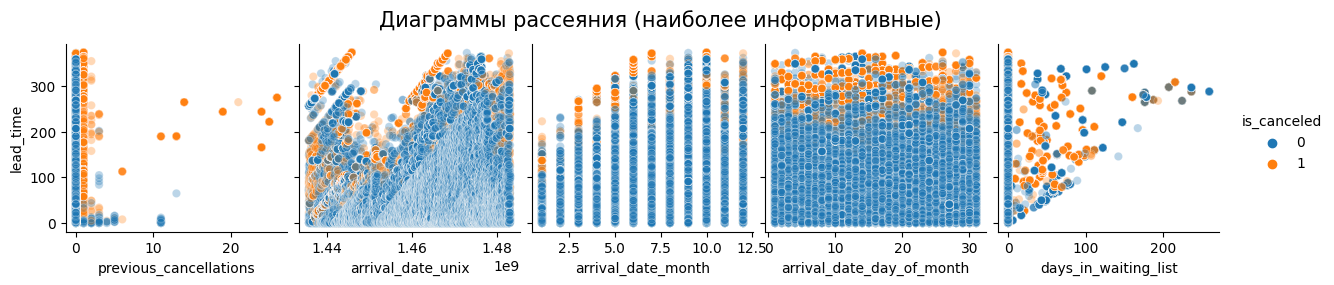

In [37]:
ax=sns.pairplot(data_ordinal,x_vars=['previous_cancellations','arrival_date_unix','arrival_date_month',
                                     'arrival_date_day_of_month','days_in_waiting_list'],
                             y_vars=['lead_time'],
                             hue='is_canceled',plot_kws=dict(alpha=0.3))
ax.fig.suptitle('Диаграммы рассеяния (наиболее информативные)', y=1.1, fontsize=15); plt.show()

Наблюдаем рассеяния соответствующие выше построенным диаграммам и вычисленной корреляции:
* бронь отменяется чаще при наличии отмен в истории клиента;
* при большем кол-ве дней между между бронированием и прибытием отмена брони происходит чаще;
* большой срок в листе ожидания связан с большим сроком предварительного бронирования; отель не торопится подтвердить бронь, пришедшую много ранее даты заезда; среди таких броней много отказов.

#### Вывод

* Пропусков нет. Названия признаков и их тип совпадают в двух df. Обучающий df примерно в 2 раза больше тестового.
* Пробелы удалены (в meal,reserved_room_type), задублированность в meal убрана.
* **arrival_date** - с июля по сентябрь 2015 года число отказов примерно ровнялось числу подтверждений; далее число отказов уменьшалось и в итоге вышло в среднем на 1/3 от общего числа броней;
* **country** - самое большое число бронирований из Португалии; скорее всего рассматриваемый отель в данном государстве; эта страна делает основную выручку; в то же время это единственная страна (по крайне мере, из топ-23) в которой количество отказов превышает число подтверждений;
* **is_canceled** - третья часть бронирований отменяется;
* **total_nights** - чаще всего бронируется номер на 2-е ночи;
* **adults, children, babies** - чаще всего в отеле останавливаются двое взрослых без детей; двое взрослых относительно одного взрослого бронируют номер в 4 раза чаще; следовательно отелем чаще пользуются туристы (пары), а не командировочные; вероятно отель в небольшом городе, т.к. наиболее частая бронь на 2 дня; удалил 2 брони с кол-ом детей 9 и 10; чем больше детей, тем дешевле номер;
* **meal** - основной тип питания - только завтраки; среди типа питания FB число отказов примерно в 2 раза выше числа подтверждений; но и типа FB кратно меньше других типов питания;
* **distribution_channel** - главный источник гостей - туристические агенства; и среди них же больше отказов;
* **reserved_room_type** - чаще всего бронируется самый дорогой номер типа А;
* **required_car_parking_spaces** - чаще гости отеля путешествуют без личных автомобилей; путешественники без собственных автомобилей отказываются от брони чаще автолюбителей;
* **total_of_special_requests** - в основном доп.запросы гости не делают; чем больше дополнительных отметок, тем меньше отказов;
* **id** - брони из обучающей и тестовой выборок не пересекаются и дополняют друг друга;
* **lead_time** - от момента бронирования до визита около двух месяцев (медиана); чем меньше срок между бронированием и заездом, тем меньше отказов; медиана подтверждённых броней - 40 дней; медиана отменённых - 100;
* **arrival_date** - тренировочный df в интервале 1,5 лет (07.2015 - 12.2016); тестовый df - 8 месяцев (01.2017 - 08.2017); оба df по времени не пересекаются;
* **arrival_date_month** - наиболее востребованные месяцы в межсезонье (май и октябрь); вероятно связано с наиболее комфортной температурой;
* **previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list** - все 4 признака в большинстве случаев со значением 0 и имеют выбросы; значения вполне могут быть реальными, удалять их не имеет смысла; при наличии предыдущих отказов от брони, отмен последнего бронирования больше; 
* мультиколлинеарность наблюдается в ряде признаков; часть удаляем для ML arrival_date_week_number, arrival_date_year, total_nights; в некоторых видах кодирования previous_bookings_not_canceled и previous_cancellations будут заменены одним признаком propensity_to_cancel;
* **days_in_waiting_list** - большой срок в листе ожидания связан с большим сроком предварительного бронирования; отель не торопится подтвердить бронь, пришедшую много ранее даты заезда; среди таких броней много отказов.

### Формулировка ML-задачи на основе бизнес-задачи

Расчитаем прибыль отеля без внедрения депозитов на тестовой выборке.

In [38]:
price    = {'A':1000,'B':800,'C':600,'D':550,'E':500,'F':450,'G':350}        # cтоимость номеров
expenses = {'A':400, 'B':350,'C':350,'D':150,'E':150,'F':150,'G':150}        # стоимость разового обслуживания (затраты)
season   = {12:1,    1:1,    2:1,                                            # сезонные к-ты увеличения цены
             3:1.2,  4:1.2,  5:1.2, 
             6:1.4,  7:1.4,  8:1.4, 
             9:1.2, 10:1.2, 11:1.2}

In [39]:
def profit (s):
    '''расчёт прибыли одного бронирования в зависимости от того подтвердилась ли бронь; на входе строка df (Series)'''
    if s['is_canceled'] == 0:
        # цена номера*сезонный к-нт*кол-во ночей - стоимость уборки*кол-во уборок
        return (price[s['reserved_room_type']]*season[s['arrival_date_month']]*s['total_nights']-
                expenses[s['reserved_room_type']]*np.ceil(s['total_nights']/2))
    else:
        # -цена номера*сезонный к-нт - стоимость уборки (убыток)
        return -price[s['reserved_room_type']]*season[s['arrival_date_month']]-expenses[s['reserved_room_type']]

In [40]:
data_test['profit'] = data_test.apply(lambda s: profit(s),axis=1) # создание признака с прибылью бронирования

In [41]:
data_test['profit'].sum() # прибыль отеля без внедрения системы депозитов за весь период тестового df (8 месяцев)

35300770.0

### Разработка модели ML

В качестве основной метрики качества возьмём f1. Попутно также будем вычислять ROC-AUC.\
В наших интересах максимально полностью выявлять клиентов склонных к отказу. Может сложиться впечатление, что идеальная метрика - recall. Тем не менее при максимизации recall мы можем уменьшить precision. Будет подозреваться в отмене брони масимальное число людей и им будет выставлено требование по предоплате. Данное требование оттолкнёт часть клиентов.

#### Кодирование

##### Ordinal Encoding (вар.2)

1. Страны с числом бронирований меньше 11 назовём 'other'.
2. Сделаем 1 признак из двух других: 'propensity_to_cancel' = 'previous_bookings_not_canceled'-'previous_cancellations'

In [42]:
# создаём признак 'country_2', в котором страны упоминаемые менее 11 раз переименуем в 'other'
data['country_2'],data_test['country_2'] = data['country'],data_test['country']

data     .loc[data     ['country'].isin(country_all.query('country_train<11').index),'country_2'] = 'other'
data_test.loc[data_test['country'].isin(country_all.query('country_test <11').index),'country_2'] = 'other'

In [43]:
# объединим в df количества стран (по 'country_2') из обучающего и тестового df
country_all_2 = pd.DataFrame(data     ['country_2'].value_counts()).join\
               (pd.DataFrame(data_test['country_2'].value_counts()), lsuffix='_train',rsuffix='_test',how='outer').\
                sort_values(by='country_2_train',ascending=False)

In [44]:
# страны присутствующие в одном df, но отсутствующие в другом
country_all_2.query('country_2_train.isna()|country_2_test.isna()').T

THA   SVN   TUN   EGY   MYS   VEN   CPV   MLT   IRQ   JOR  \
country_2_train  48.0  45.0  29.0  24.0  21.0  20.0  15.0  12.0  12.0  12.0   
country_2_test    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                  CRI   BLR   MAC   PHL   URY  
country_2_train  12.0  11.0   NaN   NaN   NaN  
country_2_test    NaN   NaN  14.0  25.0  16.0

In [45]:
# трём странам в тестовом df, которых нет в обучающем присваиваем имя 'other'
data_test.loc[data_test['country_2'].isin(country_all_2.query('country_2_train.isna()').index),'country_2'] = 'other'

In [46]:
# создание признака, который заменит 2 существующих
for d in (data,data_test):
    d['propensity_to_cancel'] = d['previous_bookings_not_canceled']-d['previous_cancellations']

In [47]:
def o_encoding_2(d):
    '''кодирует OE только тип object и убирает ненужные для ML признаки'''
    return pd.DataFrame(encoder_2.transform(d[[col for col in d if d[col].dtype == object]]),
                                    columns=d[[col for col in d if d[col].dtype == object]].columns,index=d.index).join(
                                            d[[col for col in d if d[col].dtype != object]]).\
           drop(['id','previous_bookings_not_canceled','previous_cancellations','country','arrival_date_year',
                 'arrival_date_week_number','total_nights','arrival_date','profit'],axis=1,errors='ignore')

encoder_2 = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
encoder_2.fit(data[[col for col in data if data[col].dtype == object]])

data_ordinal_2      = o_encoding_2(data)
data_test_ordinal_2 = o_encoding_2(data_test)

#####  One-Hot Encoding 

In [48]:
def ohe(d):
    '''кодирует OHE только тип object и убирает ненужные для ML признаки'''
    return pd.DataFrame(encoder_ohe.transform(d[[col for col in d if d[col].dtype == object]]).toarray(),
                        columns=encoder_ohe.get_feature_names_out(), index=d.index).join(
                                              d[[col for col in d if d[col].dtype != object]]).\
           drop(['id','previous_bookings_not_canceled','previous_cancellations','country','arrival_date_year',
                 'arrival_date_week_number','total_nights','arrival_date','profit'],axis=1,errors='ignore')

encoder_ohe = OneHotEncoder(handle_unknown = 'ignore')
encoder_ohe.fit(data[[col for col in data if data[col].dtype == object]])

data_ohe = ohe(data)
data_test_ohe = ohe(data_test)

In [49]:
# масштабируем оба датасета
scaler = StandardScaler()
scaler.fit(data_ohe)
data_ohe_scaled = pd.DataFrame(scaler.transform(data_ohe), data_ohe.index, data_ohe.columns)
data_test_ohe_scaled = pd.DataFrame(scaler.transform(data_test_ohe), data_test_ohe.index, data_test_ohe.columns)

#### Разбиение на признаки, ф-ия ML

In [50]:
# определяем признаки и целевой признак только для обучающего датасета
data_ordinal_features    = data_ordinal.drop(['is_canceled','arrival_date_week_number','arrival_date_year',
                                              'total_nights','arrival_date'],axis=1)
data_ordinal_target      = data_ordinal['is_canceled']

data_ordinal_2_features  = data_ordinal_2.drop('is_canceled',axis=1)
data_ordinal_2_target    = data_ordinal_2['is_canceled']

data_ohe_scaled_features = data_ohe_scaled.drop('is_canceled',axis=1)
data_ohe_target          = data_ohe['is_canceled']                     # целевой признак в OHE используем не масштабированный

In [51]:
def ml(algorithm, features, target, depth=None,est=100,class_weight='balanced',criterion='gini',solver='lbfgs',max_iter=1000):
    '''вычисление всех основных метрик качества модели; на входе тип алгоритма, датасеты, гиперпараметры'''
    if algorithm == 'DTC':
        model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight=class_weight,criterion=criterion)
    elif algorithm == 'RFC':
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight=class_weight,
                                       criterion=criterion)
    elif algorithm == 'LR':
        model = LogisticRegression(solver=solver, max_iter=max_iter, random_state=12345, class_weight=class_weight)
        
    return dict(map(lambda x: (x[0],x[1].mean()),
                    cross_validate(model,features,target,scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']).
                    items()))

In [52]:
# сводная итоговая таблица с метриками качества
summary = pd.DataFrame(columns = ['f1','ROC-AUC','Depth','n_estimators','criterion','class_weight','solver'])

def summary_f (ml_type, f1, roc_auc, depth, n_estimators, criterion, class_weight, solver):
    '''собирает метрики качества по разным моделям в 1 сводный df'''
    global summary
    summary = pd.concat([summary,pd.DataFrame(index=[ml_type],
                                              columns=['f1','ROC-AUC','Depth','n_estimators','criterion',
                                                       'class_weight','solver'],
                                              data=[[f1, roc_auc, depth, n_estimators,criterion,class_weight,solver]])])

#### DecisionTreeClassifier, OE 1

In [53]:
def dtc_best_hyperparameters(features,target,ml_type,criterion='gini',class_weight='balanced'):
    '''Для DecisionTreeClassifier определяет глубину для максимального f1'''
    dtc_df = pd.DataFrame(columns=['accuracy','precision','recall','f1','roc_auc'])
    for i in range (3,10):
        j = ml('DTC',features,target,depth=i,criterion=criterion,class_weight=class_weight)
        dtc_df = pd.concat([dtc_df,
                            pd.DataFrame({'accuracy': j['test_accuracy'], 
                                          'precision':j['test_precision'], 
                                          'recall':   j['test_recall'],
                                          'f1':       j['test_f1'], 
                                          'roc_auc':  j['test_roc_auc']},index=[i])])
        
    dtc_df.plot(grid=True,figsize=(6,4),xlabel='depth',
                title=f'{ml_type}, {criterion}, class_weight={class_weight} \nЗависимость метрик качества от глубины дерева')
    plt.show()
    
    print('Глубина с максимальным f1:')
    display(dtc_df.sort_values(by='f1')[-1:].round(4))
        
    summary_f(ml_type,
              dtc_df['f1'].max(),
              dtc_df['roc_auc'][dtc_df['f1'].idxmax()],
              dtc_df['f1'].idxmax(),
              '-',
              criterion,
              class_weight,
              '-')

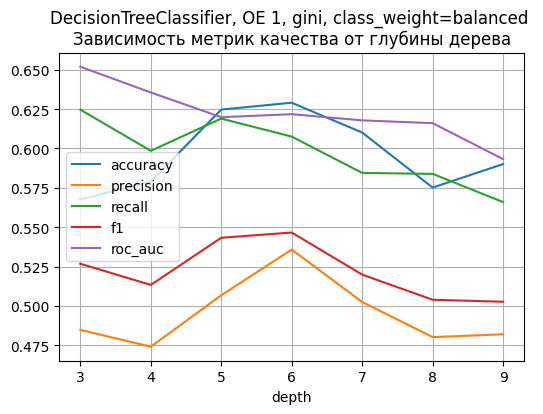

Глубина с максимальным f1:


accuracy  precision  recall      f1  roc_auc
6    0.6291     0.5358  0.6075  0.5467   0.6218

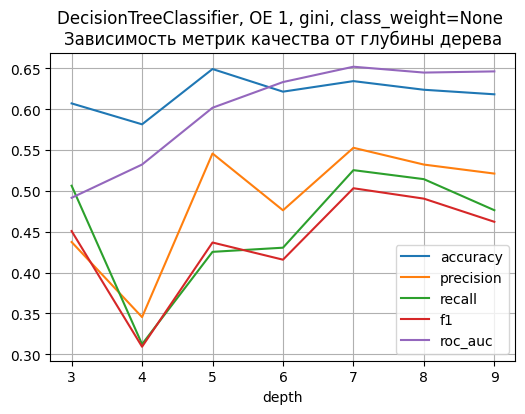

Глубина с максимальным f1:


accuracy  precision  recall      f1  roc_auc
7    0.6342     0.5526  0.5253  0.5031   0.6518

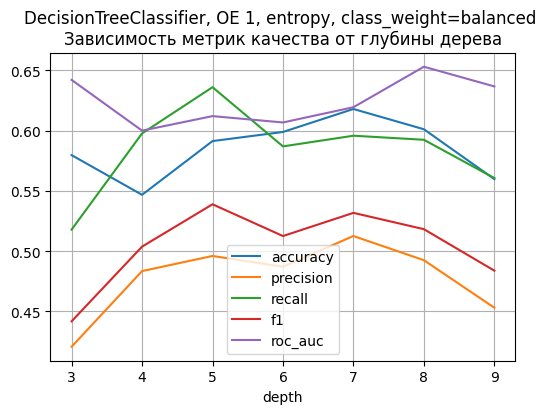

Глубина с максимальным f1:


accuracy  precision  recall      f1  roc_auc
5    0.5913      0.496   0.636  0.5389    0.612

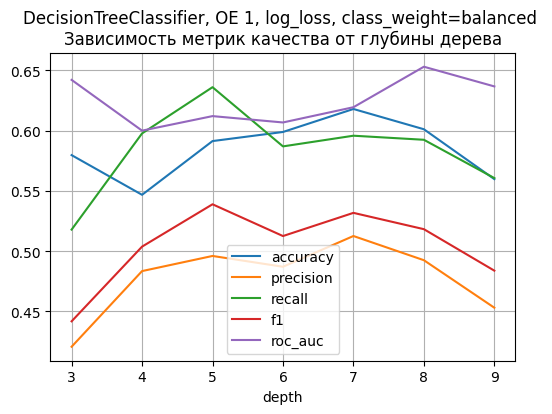

Глубина с максимальным f1:


accuracy  precision  recall      f1  roc_auc
5    0.5913      0.496   0.636  0.5389    0.612

In [54]:
# подбор гиперпараметров (глубина дерева, критерий (функционал качества разбиения данных в узле), балансировка)
for cr,cl_w in (('gini',    'balanced'),
                ('gini',     None),
                ('entropy', 'balanced'),
                ('log_loss','balanced')):
    dtc_best_hyperparameters(data_ordinal_features,data_ordinal_target,'DecisionTreeClassifier, OE 1', 
                             criterion=cr, class_weight=cl_w)

#### DecisionTreeClassifier, OE 2

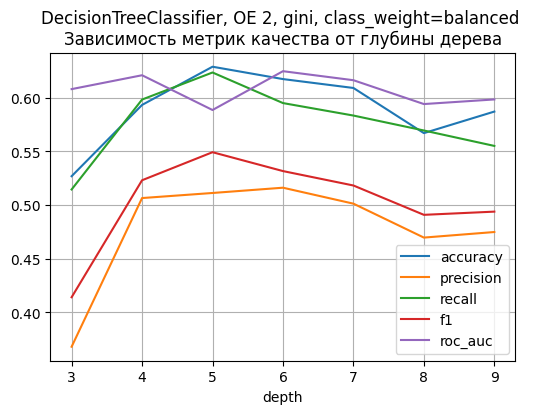

Глубина с максимальным f1:


accuracy  precision  recall      f1  roc_auc
5    0.6289     0.5112  0.6236  0.5492   0.5886

In [55]:
dtc_best_hyperparameters(data_ordinal_2_features,data_ordinal_2_target,'DecisionTreeClassifier, OE 2')

#### RandomForestClassifier, OE 1

In [56]:
def rfc_best_hyperparameters(features,target,ml_type,criterion='gini',class_weight='balanced'):
    '''Для RandomForestClassifier определяет оптимальные глубину и кол-во деревьев для максимального f1; также выдаёт ROC-AUC
    в этой точке. Алгоритм: сначала определяется глубина  для f1_max при числе деревьев 20; далее с найденной глубиной
    подбирается оптимальное число деревьев'''
    f1_df = pd.DataFrame(index=range(1,10),columns=list(range(2,20,2))+list(range(20,201,20))).astype(float)
    roc_auc_df = f1_df.copy()
    
    def rfc_make_df(features,target,depth,est):
        '''рассчитывает и заполняет df'мы значениями f1 и ROC-AUC'''
        j = ml('RFC',features,target,depth=depth,est=est,criterion=criterion,class_weight=class_weight)
        f1_df.loc[depth,est] = j['test_f1']
        roc_auc_df.loc[depth,est] = j['test_roc_auc']
        
    for depth in f1_df.index:
        rfc_make_df(features,target,depth,20)
    for est in f1_df.columns:
        rfc_make_df(features,target,f1_df[20].idxmax(),est)
        
    for df,color,title in ((f1_df,'Greens',
                            f'{ml_type}, {criterion},class_weight={class_weight} \nЗависимость f1 от глубины и числа деревев'),
                           (roc_auc_df,'Blues','Зависимость ROC-AUC от глубины и числа деревев')):
        plt.figure(figsize=(10,2.5))
        sns.heatmap(df,annot=True, linewidth=1, fmt='.3f', annot_kws={"size":7},cmap=color)
        plt.title(title); plt.xlabel('Количество деревьев'); plt.ylabel('Глубина'); plt.show()
    
    print(f'f1_max = {f1_df.max().max():.4f},\
     ROC-AUC = {roc_auc_df.loc[f1_df.max(axis=1).idxmax(),f1_df.max().idxmax()]:.4f}\
     при глубине {f1_df.max(axis=1).idxmax()} и числе деревьев {f1_df.max().idxmax()}')

    summary_f(ml_type,
              f1_df.max().max(),
              roc_auc_df.loc[f1_df.max(axis=1).idxmax(),f1_df.max().idxmax()],
              f1_df.max(axis=1).idxmax(),
              f1_df.max().idxmax(),
              criterion,
              class_weight,
              '-')

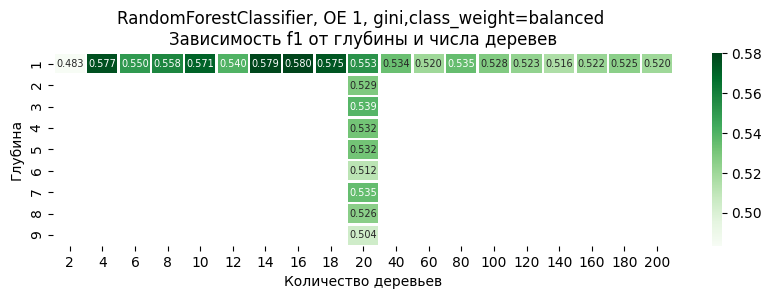

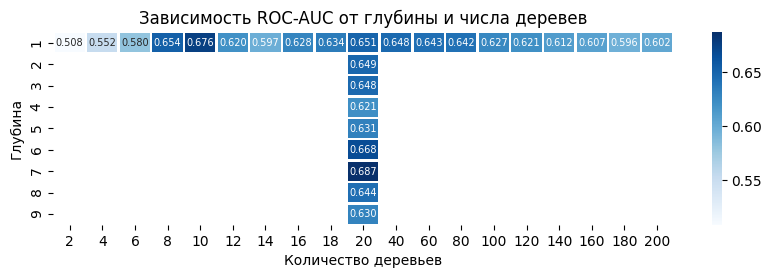

f1_max = 0.5801,     ROC-AUC = 0.6284     при глубине 1 и числе деревьев 16


In [57]:
rfc_best_hyperparameters(data_ordinal_features,data_ordinal_target,'RandomForestClassifier, OE 1')

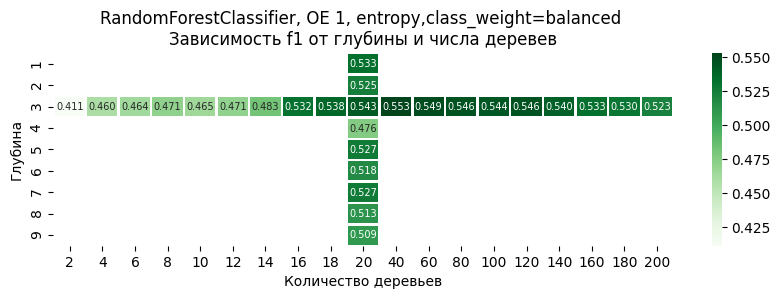

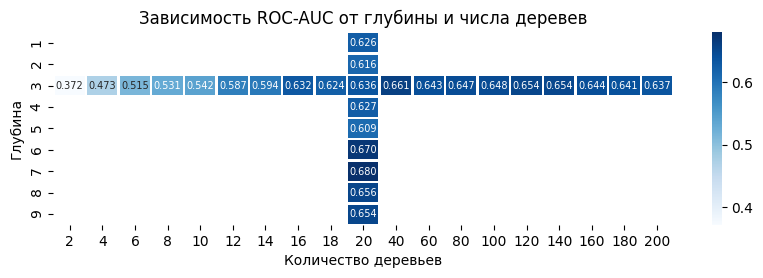

f1_max = 0.5530,     ROC-AUC = 0.6612     при глубине 3 и числе деревьев 40


In [58]:
rfc_best_hyperparameters(data_ordinal_features,data_ordinal_target,'RandomForestClassifier, OE 1',criterion='entropy')

#### RandomForestClassifier, OE 2

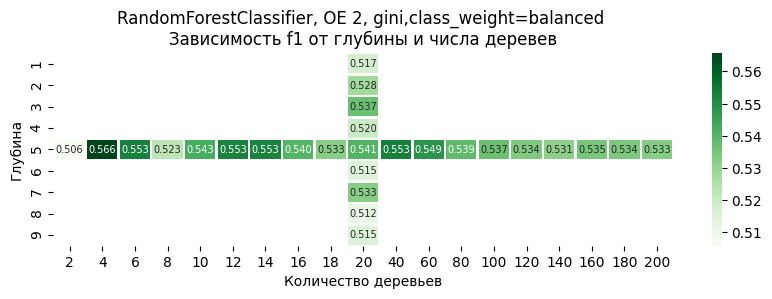

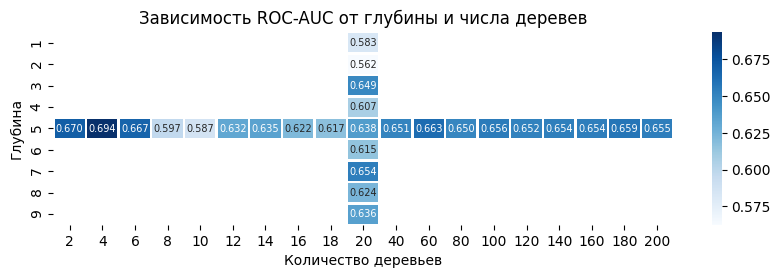

f1_max = 0.5657,     ROC-AUC = 0.6935     при глубине 5 и числе деревьев 4


In [59]:
# определяем оптимальные гиперпараметры при максимальном f1
rfc_best_hyperparameters(data_ordinal_2_features,data_ordinal_2_target,'RandomForestClassifier, OE 2')

#### DecisionTreeClassifier, OHE

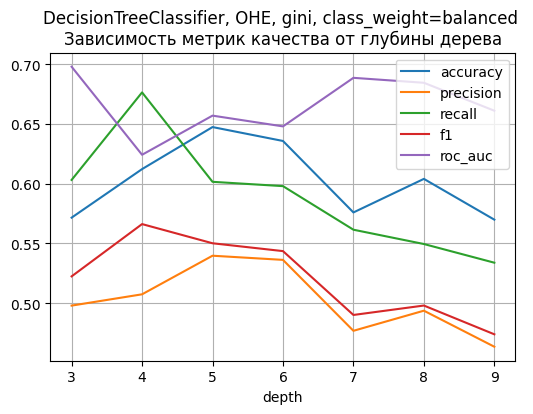

Глубина с максимальным f1:


accuracy  precision  recall      f1  roc_auc
4    0.6122     0.5074  0.6763  0.5661   0.6241

In [60]:
dtc_best_hyperparameters(data_ohe_scaled_features,data_ohe_target,'DecisionTreeClassifier, OHE')

<a id= 'rfc'></a>
#### RandomForestClassifier, OHE 

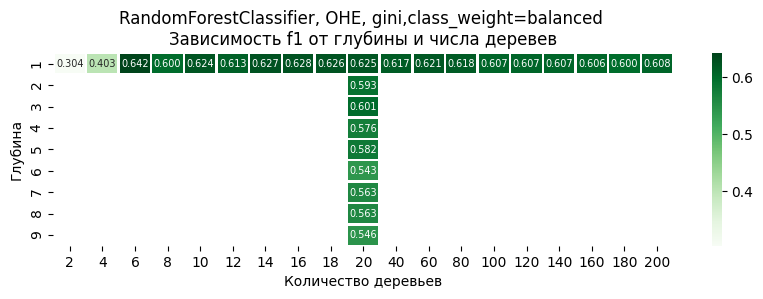

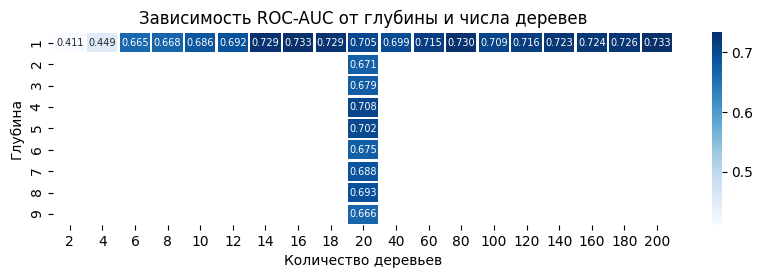

f1_max = 0.6425,     ROC-AUC = 0.6651     при глубине 1 и числе деревьев 6


In [61]:
rfc_best_hyperparameters(data_ohe_scaled_features,data_ohe_target,'RandomForestClassifier, OHE')

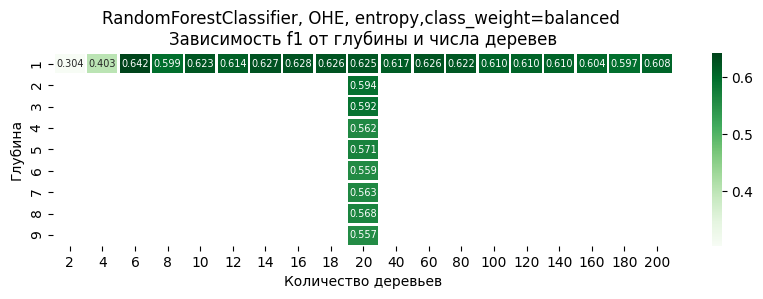

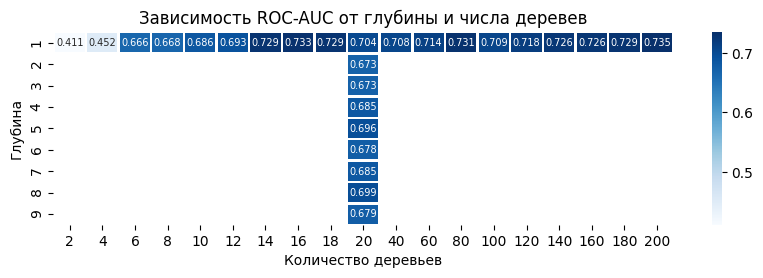

f1_max = 0.6425,     ROC-AUC = 0.6662     при глубине 1 и числе деревьев 6


In [62]:
rfc_best_hyperparameters(data_ohe_scaled_features,data_ohe_target,'RandomForestClassifier, OHE',criterion='entropy')

#### LogisticRegression, OHE

In [63]:
# подбор гиперпараметров (алгоритм в оптимизации, балансировка)
for s,cl_w in (('lbfgs',         'balanced'),
               ('lbfgs',          None),
               ('liblinear',     'balanced'),
               ('liblinear',      None),
               ('newton-cg',     'balanced'),
               ('newton-cholesky','balanced')):
    
    j = ml('LR', data_ohe_scaled_features, data_ohe_target, solver = s, class_weight=cl_w)
    print(f"f1 = {j['test_f1']:.4f},  ROC-AUC = {j['test_roc_auc']:.4f}  (solver={s}, class_weight={cl_w})")
    
    summary_f('LogisticRegression, OHE', j['test_f1'],  j['test_roc_auc'], '-', '-','-', cl_w, s) 

f1 = 0.6227,  ROC-AUC = 0.8101  (solver=lbfgs, class_weight=balanced)
f1 = 0.6080,  ROC-AUC = 0.8104  (solver=lbfgs, class_weight=None)
f1 = 0.6226,  ROC-AUC = 0.8101  (solver=liblinear, class_weight=balanced)
f1 = 0.6080,  ROC-AUC = 0.8106  (solver=liblinear, class_weight=None)
f1 = 0.6225,  ROC-AUC = 0.8096  (solver=newton-cg, class_weight=balanced)
f1 = 0.6225,  ROC-AUC = 0.8096  (solver=newton-cholesky, class_weight=balanced)


#### Вывод по ML

In [64]:
summary.round(4).sort_values(by='f1',ascending=False)

f1  ROC-AUC Depth n_estimators criterion  \
RandomForestClassifier, OHE   0.6425   0.6651     1            6      gini   
RandomForestClassifier, OHE   0.6425   0.6662     1            6   entropy   
LogisticRegression, OHE       0.6227   0.8101     -            -         -   
LogisticRegression, OHE       0.6226   0.8101     -            -         -   
LogisticRegression, OHE       0.6225   0.8096     -            -         -   
LogisticRegression, OHE       0.6225   0.8096     -            -         -   
LogisticRegression, OHE       0.6080   0.8106     -            -         -   
LogisticRegression, OHE       0.6080   0.8104     -            -         -   
RandomForestClassifier, OE 1  0.5801   0.6284     1           16      gini   
DecisionTreeClassifier, OHE   0.5661   0.6241     4            -      gini   
RandomForestClassifier, OE 2  0.5657   0.6935     5            4      gini   
RandomForestClassifier, OE 1  0.5530   0.6612     3           40   entropy   
DecisionTreeClassifier, OE 2  0.5492   0.5886     5            -      gini   
DecisionTreeClassifier, OE 1  0.5467   0.6218     6            -      gini   
DecisionTreeClassifier, OE 1  0.5389   0.6120     5            -  log_loss   
DecisionTreeClassifier, OE 1  0.5389   0.6120     5            -   entropy   
DecisionTreeClassifier, OE 1  0.5031   0.6518     7            -      gini   

                             class_weight           solver  
RandomForestClassifier, OHE      balanced                -  
RandomForestClassifier, OHE      balanced                -  
LogisticRegression, OHE          balanced            lbfgs  
LogisticRegression, OHE          balanced        liblinear  
LogisticRegression, OHE          balanced  newton-cholesky  
LogisticRegression, OHE          balanced        newton-cg  
LogisticRegression, OHE              None        liblinear  
LogisticRegression, OHE              None            lbfgs  
RandomForestClassifier, OE 1     balanced                -  
DecisionTreeClassifier, OHE      balanced                -  
RandomForestClassifier, OE 2     balanced                -  
RandomForestClassifier, OE 1     balanced                -  
DecisionTreeClassifier, OE 2     balanced                -  
DecisionTreeClassifier, OE 1     balanced                -  
DecisionTreeClassifier, OE 1     balanced                -  
DecisionTreeClassifier, OE 1     balanced                -  
DecisionTreeClassifier, OE 1         None                -

Лучшая модель RandomForestClassifier незначительно опережает LogisticRegression.\
В то же время ROC-AUC у логистической модели много выше.\
Следователно LogisticRegression - модель более стабильная и, в целом, лучше определяет брони склонные к отказу.\
Случайность лидерства "деревянной" модели также видна [выше](#rfc) на диаграмме: вокруг максимального значения f1 резкое падение метрики.\
В производство задаём LogisticRegression с алгоритмом оптимизации "lbfgs", числом итераций 1000, и отбалансированной выборкой.

#### Проверка лучшей модели на тестовом df

In [65]:
# масштабируем закодированные (OHE) признаки тестового df (целевой не масштабируем)
data_test_ohe_scaled_features = data_test_ohe_scaled.drop('is_canceled',axis=1)
data_test_ohe_target = data_test_ohe['is_canceled']                     # целевой признак в OHE используем не масштабированный

In [66]:
model = LogisticRegression(solver='lbfgs', random_state=12345, class_weight='balanced', max_iter=1000)
model.fit(data_test_ohe_scaled_features,data_test_ohe_target)

data_test['prediction'] = model.predict(data_test_ohe_scaled_features)
data_test['probability'] = model.predict_proba(data_test_ohe_scaled_features)[:,1]

print(f"f1 = {f1_score(data_test_ohe_target, data_test['prediction']):.4f},\
   ROC-AUC = {roc_auc_score(data_test_ohe_target, data_test['probability']):.4f}")

f1 = 0.6980,   ROC-AUC = 0.8422


Метрики качества на тестовом df ещё выше, чем на обучающем.

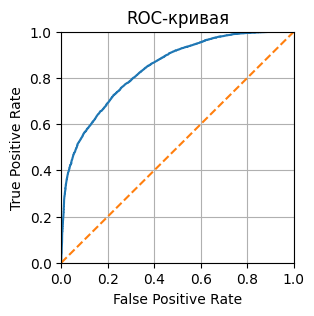

In [67]:
fpr, tpr, thresholds = roc_curve(data_test_ohe_target, data_test['probability'])

plt.figure(figsize=(3,3))
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0]); plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC-кривая'); plt.grid(True); plt.show()

#### Оценка прибыли от ML

In [68]:
def profit_predict(s):
    '''расчёт предсказанной прибыли одного бронирования в зависимости от предсказания ML и факта подтверждения или отмены брони;
    на входе строка df (Series).
    Логика:
    <постоялец отменил бронь (значение в profit “-“)> , <модель предсказала отмену брони>
    0, 0 — прибыль отеля не меняется, в profit_predicted будет то же значение, что и в profit. 
    0, 1 — постоялец внесёт предоплату, которая пойдёт в счёт оплаты, то есть в этом случае прибыль отеля тоже 
           никак не меняется, в profit_predicted будет то же значение, что и в profit.
    1, 0 — предоплату с такого клиента не брали; прибыль отеля тоже никак не меняется, отель потерял деньги, 
           в profit_predicted будет то же отрицательное значение, что и в profit. 
    1, 1 — остается 20% от убытков до внедрения модели (т.к. депозит 80% от первых суток с уборкой).'''
    
    if s['is_canceled'] == 1 and s['prediction'] == 1:
        return 0.2*s['profit']
    else:
        return s['profit']

In [69]:
data_test['profit_predicted'] = data_test.apply(lambda s: profit_predict(s),axis=1) # прибыль брони с учётом ML

In [70]:
# общая прибыль (принесённая ML) после внедрения системы депозитов за 8 месяцев тестового периода(январь-август)
data_test['profit_predicted'].sum()-data_test['profit'].sum()

10869272.0

Прибыль, которую принесёт модель за год спрогнозируем с помощью следующей логики:\
Прибыль{январь-август} (известна) + \
Прибыль{сентябрь-ноябрь} (неизвестна; возьмём весенний период март-май, но с учётом соотношения среднего числа бронирований в предыдущие периоды "<font color='blue'>осень/весна</font>") + \
Прибыль{декабрь} (неизвестна; возьмём среднюю прибыль зимних месяцев январь-февраль, но с учётом соотношения среднего числа бронирований в предыдущие периоды "<font color='blue'>дек.  /  (янв.+февр.)/2</font>")

In [71]:
# среднемесячное число бронирований по обучающему df
past_bookings_mean = data.groupby(['arrival_date_year','arrival_date_month'])['id'].count().\
                          groupby('arrival_date_month').mean()
past_bookings_mean

arrival_date_month
1     1891.0
2     3358.0
3     4148.0
4     4804.0
5     4677.0
6     4659.0
7     2859.0
8     3339.0
9     4391.0
10    4627.0
11    2880.5
12    2748.5
Name: id, dtype: float64

In [72]:
# соотношение среднего числа бронирований в предыдущие периоды "осень/весна"
ratio_autumn_spring = past_bookings_mean.loc[9:11].sum()/past_bookings_mean.loc[3:5].sum()
ratio_autumn_spring

0.8730281018416611

In [73]:
# соотношение среднего числа бронирований в предыдущие периоды "дек. / (янв.+февр.)/2 "
ratio_winter = past_bookings_mean.loc[12] / past_bookings_mean.loc[1:2].mean()
ratio_winter

1.047247094684702

In [74]:
# прибыль {январь-август}
(data_test['profit_predicted'].sum()-data_test['profit'].sum() +

 # прибыль {сентябрь-ноябрь} 
 (data_test.query('arrival_date_month in [3,4,5]')['profit_predicted'].sum()-
  data_test.query('arrival_date_month in [3,4,5]')['profit'].sum())*ratio_autumn_spring +

 # прибыль {декабрь} 
 ((data_test.query('arrival_date_month == 1')['profit_predicted'].sum()-
   data_test.query('arrival_date_month == 1')['profit'].sum()+
   data_test.query('arrival_date_month == 2')['profit_predicted'].sum()-
   data_test.query('arrival_date_month == 2')['profit'].sum())/2)*ratio_winter)

16088893.83980924

### Общий вывод

**Главное:**
* Для решения поставленной задачи выбрана модель LogisticRegression с кодированием One-Hot Encoding, с балансировкой, с алгоритмом оптимизации 'lbfgs' и количеством итераций 1000.\
  Выбранная модель проверена на тестовой выборке:<br> 
  f1 = 0.6980, ROC-AUC = 0.8422.
* Общая прибыль (принесённая ML) после внедрения системы депозитов за 8 месяцев тестового периода(январь-август):<br>10.9 млн.
* Прогнозируемая годовая прибыль, принесённая моделью:<br>16.1 млн.

Таким образом, модель окупила затраты на свою разработку в 0.4 млн. (в расчёте прибыли не учтены).


**Портрет «ненадёжного» клиента:**
* ранее уже отменял брони;
* забронировал ранее 30(примерно) дней до заезда;
* склонен к типу питания FB.

Также есть ряд признаков, среди которых доля отказов велика. Но в тоже время люди соответсвующие этим критериям делают основную кассу. Поэтому относить их к "ненадёжным" не следует, но знать про них рекомендуется:
* португалец, без собственного автомобиля, купивший путёвку в турагенстве и не делающий дополнительные пометки.

**Анализ данных:**
* С июля по сентябрь 2015 года число отказов примерно ровнялось числу подтверждений; далее число отказов уменьшалось и в итоге вышло в среднем на 1/3 от общего числа броней.
* Самое большое число бронирований из Португалии; скорее всего рассматриваемый отель в данном государстве; эта страна делает основную выручку; в то же время это единственная страна (по крайне мере, из топ-23) в которой количество отказов превышает число подтверждений.
* Третья часть бронирований отменяется.
* Чаще всего бронируется номер на 2-е ночи.
* Чаще всего в отеле останавливаются двое взрослых без детей; отелем чаще пользуются туристы (пары), а не командировочные; вероятно отель в небольшом городе, т.к. наиболее частая бронь на 2 дня.
* Основной тип питания - только завтраки; среди типа питания FB число отказов примерно в 2 раза выше числа подтверждений.
* Главный источник гостей - туристические агенства; и среди них же больше отказов.
* Чаще всего бронируется самый дорогой номер типа А.
* Чаще гости отеля путешествуют без личных автомобилей; путешественники без собственных автомобилей отказываются от брони чаще автолюбителей.
* В основном доп.запросы гости не делают; чем больше дополнительных отметок, тем меньше отказов.
* От момента бронирования до визита около двух месяцев (медиана); чем меньше срок между бронированием и заездом, тем меньше отказов.
* Тренировочный df в интервале 1,5 лет (07.2015 - 12.2016); тестовый df - 8 месяцев (01.2017 - 08.2017); оба df по времени не пересекаются.
* Наиболее востребованные месяцы в межсезонье (май и октябрь).
* Большой срок в листе ожидания связан с большим сроком предварительного бронирования.

**Рекомендации:**
* снизить цену на номера летом, т.к. спрос в этот период уменьшается.